In [1]:
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

mred = u"#d62728"
morange = u"#ff7f0e"
mgreen = u"#2ca02c"
mblue = u"#1f77b4"
mpurple = u"#9467bd"
plt.rc('font', family="serif")
plt.rc('font', size=22)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}') #necessary to use \dfrac
colors = ["#0077BB", "#33BBEE", "#009988", "#EE7733", "#CC3311", "#EE3377", '#882255', '#AA4499']


In [3]:
from jax import numpy as jnp
from jax import jit as jjit
from jax import vmap
import os
import h5py
import time


In [4]:
from diffstar.utils import _get_dt_array
from diffstar.fit_smah_helpers import get_header, load_diffstar_data
from diffstar.stars import (
    calculate_sm_sfr_fstar_history_from_mah,
    compute_fstar,
    compute_fstar_vmap,
    _sfr_eff_plaw,
    _get_bounded_sfr_params, 
    _get_unbounded_sfr_params,
    calculate_histories,
    calculate_histories_vmap,
    calculate_histories_batch,
    fstar_tools,
)

from diffstar.constants import TODAY
from diffstar.quenching import _get_bounded_q_params, _get_unbounded_q_params
from diffmah.individual_halo_assembly import _calc_halo_history


def calculate_fstar_data_batch(tarr, sm_cumsum, index_select, index_high, fstar_tdelay):
    ng = len(sm_cumsum)
    nt = len(index_high)
    fstar = np.zeros((ng,nt))
    indices = np.array_split(np.arange(ng), int(ng/5000))
    for inds in indices:
        fstar[inds] = compute_fstar_vmap(tarr, sm_cumsum[inds], index_select, index_high, fstar_tdelay)
    return fstar
    
def _calculate_sm(lgt, dt, mah_params, sfr_params, q_params, index_select, index_high, fstar_tdelay):
    dmhdt, log_mah = _calc_halo_history(lgt, *mah_params)
    mstar, sfr, fstar = calculate_sm_sfr_fstar_history_from_mah(
        lgt, dt, dmhdt, log_mah, sfr_params, q_params,
        index_select,
        index_high,
        fstar_tdelay
    )
    return mstar, sfr, fstar, dmhdt, log_mah



calculate_sm = jjit(vmap(_calculate_sm, in_axes=(None, None, 0, 0, 0, None, None, None)))



/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


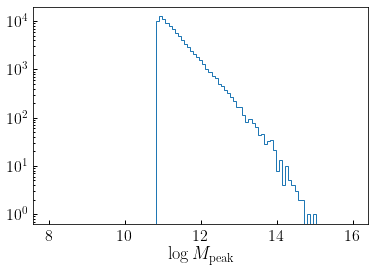

In [5]:
from astropy.cosmology import Planck15



data_path = "/Users/alarcon/Documents/diffmah_data/"
results_path = data_path

halos_SMDPL = np.load(data_path+'SMDPL_subvol0..9.npz')
SMDPL_a = np.load(data_path+"scale_list_SMDPL.npy")
SMDPL_z = 1.0 / SMDPL_a - 1.0
SMDPL_t = Planck15.age(SMDPL_z).value

dt_SMDPL = _get_dt_array(SMDPL_t)

H_SMDPL = 0.6777
# From https://www.cosmosim.org/cms/simulations/smdpl/
# The mass particle resolution is 9.63e7 Msun/h
particle_mass_res = 9.63e7 / H_SMDPL
# So we cut halos with M0 below 500 times the mass resolution.
logmpeak_fit_min = np.log10(500 * particle_mass_res)

sm_cumsum_SMDPL = np.cumsum(halos_SMDPL['sfr_history_main_prog']*dt_SMDPL,axis=1)*1e9
mhalo_SMDPL = np.maximum.accumulate(halos_SMDPL["mpeak_history_main_prog"], axis=1)
logmpeak_SMDPL = np.log10(mhalo_SMDPL[:, -1])
sfrh_SMDPL = halos_SMDPL['sfr_history_main_prog']
sSFR_SMDPL = halos_SMDPL["sfr_history_main_prog"] / sm_cumsum_SMDPL

sel = logmpeak_SMDPL >= logmpeak_fit_min

sm_cumsum_SMDPL = sm_cumsum_SMDPL[sel]
mhalo_SMDPL = mhalo_SMDPL[sel]
logmpeak_SMDPL = logmpeak_SMDPL[sel]
sfrh_SMDPL = sfrh_SMDPL[sel]
sSFR_SMDPL = sSFR_SMDPL[sel]


_bins = np.linspace(8,16,100)
plt.hist(logmpeak_SMDPL, bins=_bins, histtype='step')
plt.xlabel(r'$\log M_{\rm{peak}}$')
plt.yscale('log')
plt.show()


def get_mah_params(runname1):
    
    fitting_data = dict()

    fn = f"{data_path}{runname1}"
    with h5py.File(fn, 'r') as hdf:
        for key in hdf.keys():
            if key == 'halo_id':
                fitting_data[key] = hdf[key][...]
            else:
                fitting_data['fit_'+key] = hdf[key][...]
                
    mah_params = np.array([
        np.log10(fitting_data['fit_t0']),
        fitting_data['fit_logmp_fit'],
        fitting_data['fit_mah_logtc'],
        fitting_data['fit_mah_k'],
        fitting_data['fit_early_index'],
        fitting_data['fit_late_index'], 
    ]).T
    return mah_params
            
            
mah_params_SMDPL_arr = []  
for i in range(10):
    runname1 = "run1_SMDPL_diffmah_default_%d.h5"%i
    mah_params_SMDPL_arr.append(get_mah_params(runname1))
    
mah_params_SMDPL = np.concatenate(mah_params_SMDPL_arr, axis=0)

            
            
fstar_tdelay = 1.0
index_select_SMDPL, fstar_indx_high_SMDPL = fstar_tools(SMDPL_t, fstar_tdelay)

lgt_SMDPL = np.log10(SMDPL_t)


fstar_data_SMDPL = calculate_fstar_data_batch(SMDPL_t, sm_cumsum_SMDPL, index_select_SMDPL, fstar_indx_high_SMDPL, fstar_tdelay)

In [6]:
def get_multiple_diffstar_res():
    mstar_arr = []
    sfr_arr = []
    fstar_arr = []
    dmhdt_arr = []
    log_mah_arr = []
    fit_params_arr = []
    u_fit_params_arr = []
    loss_arr = []
    success_arr = []

    _res_SMDPL = []
    for i in range(10):
        runname1 = "run1_SMDPL_diffstar_default_%i.h5"%i
        _res_SMDPL = load_diffstar_data(runname1, SMDPL_t, fstar_tdelay, mah_params_SMDPL_arr[i], results_path)

        mstar_arr.append(_res_SMDPL[0][0])
        sfr_arr.append(_res_SMDPL[0][1])
        fstar_arr.append(_res_SMDPL[0][2])
        dmhdt_arr.append(_res_SMDPL[0][3])
        log_mah_arr.append(_res_SMDPL[0][4])
        fit_params_arr.append(_res_SMDPL[1])
        u_fit_params_arr.append(_res_SMDPL[2])
        loss_arr.append(_res_SMDPL[3])
        success_arr.append(_res_SMDPL[4])

    mstar_arr = np.concatenate(mstar_arr, axis=0)
    sfr_arr = np.concatenate(sfr_arr, axis=0)
    fstar_arr = np.concatenate(fstar_arr, axis=0)
    dmhdt_arr = np.concatenate(dmhdt_arr, axis=0)
    log_mah_arr = np.concatenate(log_mah_arr, axis=0)
    fit_params_arr = np.concatenate(fit_params_arr, axis=0)
    u_fit_params_arr = np.concatenate(u_fit_params_arr, axis=0)
    loss_arr = np.concatenate(loss_arr, axis=0)
    success_arr = np.concatenate(success_arr, axis=0)

    res = (
        (
            mstar_arr,
            sfr_arr,
            fstar_arr,
            dmhdt_arr,
            log_mah_arr,
        ),
        fit_params_arr,
        u_fit_params_arr,
        loss_arr,
        success_arr
    )

    return res

res_SMDPL = get_multiple_diffstar_res()

(9498, 117) (array(['Fail', 'L-BFGS-B'], dtype='<U8'), array([  10, 9488]))
(9092, 117) (array(['Fail', 'L-BFGS-B'], dtype='<U8'), array([   5, 9087]))
(9081, 117) (array(['Fail', 'L-BFGS-B'], dtype='<U8'), array([   8, 9073]))
(9242, 117) (array(['Fail', 'L-BFGS-B'], dtype='<U8'), array([   5, 9237]))
(9333, 117) (array(['Fail', 'L-BFGS-B'], dtype='<U8'), array([   5, 9328]))
(9408, 117) (array(['Fail', 'L-BFGS-B'], dtype='<U8'), array([   4, 9404]))
(9217, 117) (array(['Fail', 'L-BFGS-B'], dtype='<U8'), array([   2, 9215]))
(9179, 117) (array(['Fail', 'L-BFGS-B'], dtype='<U8'), array([   6, 9173]))
(9652, 117) (array(['Fail', 'L-BFGS-B'], dtype='<U8'), array([  14, 9638]))
(9657, 117) (array(['Fail', 'L-BFGS-B'], dtype='<U8'), array([  14, 9643]))


In [7]:
sfh_params = res_SMDPL[1]

In [8]:
from diffstarpop.pdf_quenched import DEFAULT_SFH_PDF_QUENCH_PARAMS, get_smah_means_and_covs_quench
from diffstarpop.pdf_mainseq import DEFAULT_SFH_PDF_MAINSEQ_PARAMS, get_smah_means_and_covs_mainseq

In [9]:
from diffstarpop.monte_carlo_halo_population import mc_sfh_population, mc_sfh_histories_Q, mc_sfh_histories_MS, mc_sfh_histories_MIX


In [10]:
t_table = np.linspace(1.0,TODAY, 100)
fstar_tdelay = 1.0
index_select, index_high = fstar_tools(t_table, fstar_tdelay=fstar_tdelay)

logm0_binmids = np.linspace(11.5, 13.5, 3)
logm0_bin_widths = np.ones_like(logm0_binmids) * 0.1

sm_loss_weight = jnp.where(t_table>2.0, 1.0, 1e10)
fstar_loss_MS_weight = jnp.where(t_table[index_select]>2.0, 1.0, 1e10)
fstar_loss_Q_weight = jnp.where(t_table[index_select]>5.0, 1.0, 1e10)

sm_loss_sel = np.arange(len(t_table))[t_table>1.0]
fstar_loss_MS_sel = np.arange(len(t_table[index_select]))[t_table[index_select]>2.0]
fstar_loss_Q_sel = np.arange(len(t_table[index_select]))[t_table[index_select]>5.0]
"""
sm_loss_sel = np.arange(len(t_table))[t_table>0.0]
fstar_loss_MS_sel = np.arange(len(t_table[index_select]))[t_table[index_select]>0.0]
fstar_loss_Q_sel = np.arange(len(t_table[index_select]))[t_table[index_select]>0.0]
"""


'\nsm_loss_sel = np.arange(len(t_table))[t_table>0.0]\nfstar_loss_MS_sel = np.arange(len(t_table[index_select]))[t_table[index_select]>0.0]\nfstar_loss_Q_sel = np.arange(len(t_table[index_select]))[t_table[index_select]>0.0]\n'

In [11]:
from diffmah.monte_carlo_halo_population import mc_halo_population
N = 10
logmpeak_diffmahpop = []
mah_params_diffmahpop = []
for binmid in logm0_binmids:
    _res = mc_halo_population(t_table, TODAY, binmid * np.ones(N))
    _mahparams = np.array([
        np.ones(N)*np.log10(TODAY),
        binmid * np.ones(N),
        _res[4],
        np.ones(N)*3.5,
        _res[2],
        _res[3],
    ]).T
    
    logmpeak_diffmahpop.append(binmid * np.ones(N))
    mah_params_diffmahpop.append(_mahparams)

    
#mah_params_diffmahpop_scan = np.array(mah_params_diffmahpop)
logmpeak_diffmahpop = np.concatenate(logmpeak_diffmahpop)
mah_params_diffmahpop = np.concatenate(mah_params_diffmahpop)

In [12]:
#DEFAULT_SFH_PDF_QUENCH_PARAMS['frac_quench_x0'] = 12.06 # default
#DEFAULT_SFH_PDF_QUENCH_PARAMS['frac_quench_x0'] = 20.0 # all is quenched?
#DEFAULT_SFH_PDF_QUENCH_PARAMS['frac_quench_x0'] = 0.0 # nothing is quenched?
DEFAULT_SFH_PDF_QUENCH_PARAMS

OrderedDict([('frac_quench_x0', 12.06),
             ('frac_quench_k', 1.27),
             ('frac_quench_ylo', -0.81),
             ('frac_quench_yhi', 1.78),
             ('mean_ulgm_quench_ylo', 11.75),
             ('mean_ulgm_quench_yhi', 12.32),
             ('mean_ulgy_quench_ylo', 0.96),
             ('mean_ulgy_quench_yhi', -0.63),
             ('mean_ul_quench_ylo', -2.23),
             ('mean_ul_quench_yhi', 2.48),
             ('mean_utau_quench_ylo', 23.2),
             ('mean_utau_quench_yhi', -21.89),
             ('mean_uqt_quench_ylo', 1.67),
             ('mean_uqt_quench_yhi', -0.01),
             ('mean_uqs_quench_ylo', -3.61),
             ('mean_uqs_quench_yhi', 4.13),
             ('mean_udrop_quench_ylo', 0.33),
             ('mean_udrop_quench_yhi', -5.13),
             ('mean_urej_quench_ylo', 1.24),
             ('mean_urej_quench_yhi', -3.41),
             ('cov_ulgm_ulgm_quench_ylo', -1.0),
             ('cov_ulgm_ulgm_quench_yhi', -1.0),
             ('cov_

In [13]:
def _get_MC_validation_quantities(N_mc_halos, kind="Q", diff_imp='vmap'):

    
    mstar_MC = np.zeros((len(logm0_binmids), N_mc_halos, len(t_table)))
    sfr_MC = np.zeros((len(logm0_binmids), N_mc_halos, len(t_table)))
    fstar_MC = np.zeros((len(logm0_binmids), N_mc_halos, len(index_select)))

    _halo_sub_mask_indices = []

    for i in range(len(logm0_binmids)):
        #mask = (logmpeak_SMDPL>logm0_binmids[i]-logm0_bin_widths[i]) & (logmpeak_SMDPL<logm0_binmids[i]+logm0_bin_widths[i]) 
        #mask &= (sfh_params[:,5] < np.log10(TODAY))
        #mask = np.arange(len(logmpeak_SMDPL))[mask]#[:50]
        
        mask = (logmpeak_diffmahpop>logm0_binmids[i]-logm0_bin_widths[i]) & (logmpeak_diffmahpop<logm0_binmids[i]+logm0_bin_widths[i]) 
        mask = np.arange(len(logmpeak_diffmahpop))[np.array(mask)]#[:50]        
        
        _halo_sub_mask_indices.append(mask)
        
        if kind=="Q":
            _fun = mc_sfh_population_Q 
            pdf_params = DEFAULT_SFH_PDF_QUENCH_PARAMS
        elif kind=="MS":
            _fun = mc_sfh_population_MS
            pdf_params = DEFAULT_SFH_PDF_MAINSEQ_PARAMS
        elif kind=="FULL":
            _fun = mc_sfh_population
        else:
            raise NotImplementedError

        if kind=="FULL":
            _res = _fun(
                jnp.log10(t_table),
                _get_dt_array(t_table),
                jnp.array([logm0_binmids[i]]),
                # mah_params_SMDPL[mask],
                mah_params_diffmahpop[mask],
                N_mc_halos,
                index_select,
                index_high,
                fstar_tdelay,
                seed=0,
                pdf_parameters_MS=DEFAULT_SFH_PDF_MAINSEQ_PARAMS,
                pdf_parameters_Q=DEFAULT_SFH_PDF_QUENCH_PARAMS,
                diffstar_kernel=diff_imp
            )
        else:
            _res = _fun(
                jnp.log10(t_table),
                _get_dt_array(t_table),
                jnp.array([logm0_binmids[i]]),
                # mah_params_SMDPL[mask],
                mah_params_diffmahpop[mask],
                N_mc_halos,
                index_select,
                index_high,
                fstar_tdelay,
                seed=0,
                pdf_parameters=pdf_params
            )
            
        mstar_MC[i] = _res[0]
        sfr_MC[i] = _res[1]
        fstar_MC[i] = _res[2]

    sFstar = fstar_MC / mstar_MC[:, :, index_select]

    _halo_sub_mask_indices = np.concatenate(_halo_sub_mask_indices)
    _halo_sub_mask_indices.shape
    
    _MC_res = []
    _MC_res.append( np.nanmean(np.log10(mstar_MC), axis=1) )
    _MC_res.append( np.nanstd(np.log10(mstar_MC), axis=1)**2 )

    _dum = fstar_MC.copy()
    _dum[(sFstar<1e-11)] = np.nan
    _MC_res.append( np.nanmean(np.log10(_dum), axis=1) )

    _dum = fstar_MC.copy()
    _dum[(sFstar>1e-11)] = np.nan
    _MC_res.append( np.nanmean(np.log10(_dum), axis=1) )

    _dum = fstar_MC.copy()
    _dum[(sFstar<1e-11)] = np.nan
    _MC_res.append( np.nanstd(np.log10(_dum), axis=1)**2 )

    _dum = fstar_MC.copy()
    _dum[(sFstar>1e-11)] = np.nan
    _MC_res.append( np.nanstd(np.log10(_dum), axis=1)**2 )


    _dum = np.sum(sFstar<1e-11,axis=1) / (np.sum(sFstar<1e-11,axis=1) + np.sum(sFstar>1e-11,axis=1))

    _MC_res.append( _dum )


    sm_mean_MC, sm_var_MC = _MC_res[0:2]
    fstar_mean_MS_MC, fstar_mean_Q_MC = _MC_res[2:4]
    fstar_var_MS_MC, fstar_var_Q_MC = _MC_res[4:6]
    quench_frac_MC = _MC_res[6]
    
    return _MC_res, _halo_sub_mask_indices, mstar_MC, sfr_MC



In [ ]:

t0 = time.time()
_MC_res_Q, _halo_sub_mask_indices_Q, mstar_MC_Q, sfr_MC_Q = _get_MC_validation_quantities(100000, kind="Q")
t1 = time.time()
print(t1-t0)

t0 = time.time()
_MC_res_MS, _halo_sub_mask_indices_MS, mstar_MC_MS, sfr_MC_MS = _get_MC_validation_quantities(100000, kind="MS")
t1 = time.time()
print(t1-t0)

t0 = time.time()
_MC_res, _halo_sub_mask_indices, mstar_MC, sfr_MC = _get_MC_validation_quantities(100000, kind="FULL")
t1 = time.time()
print(t1-t0)


In [14]:
t0 = time.time()
_MC_res, _halo_sub_mask_indices, mstar_MC, sfr_MC = _get_MC_validation_quantities(100000, kind="FULL", diff_imp='vmap')
t1 = time.time()
print(t1-t0)
t0 = time.time()
_MC_res_scan, _halo_sub_mask_indices_scan, mstar_MC_scan, sfr_MC_scan = _get_MC_validation_quantities(100000, kind="FULL", diff_imp='scan')
t1 = time.time()
print(t1-t0)

/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


22.244380712509155
27.92633605003357


In [12]:
n_histories = int(1e5)
n_halos_per_bin = 10

t0 = time.time()
_MC_res = mc_sfh_population(
    t_table,
    logm0_binmids,
    logm0_bin_widths,
    n_halos_per_bin,
    mah_params_diffmahpop,
    n_histories,
    fstar_tdelay=1.0,
    population="MIX",
    pdf_parameters_MS=DEFAULT_SFH_PDF_MAINSEQ_PARAMS,
    pdf_parameters_Q=DEFAULT_SFH_PDF_QUENCH_PARAMS,
    diffstar_kernel="vmap",
)
t1 = time.time()
print(t1-t0)
t0 = time.time()
_MC_res_scan = mc_sfh_population(
    t_table,
    logm0_binmids,
    logm0_bin_widths,
    n_halos_per_bin,
    mah_params_diffmahpop,
    n_histories,
    fstar_tdelay=1.0,
    population="MIX",
    pdf_parameters_MS=DEFAULT_SFH_PDF_MAINSEQ_PARAMS,
    pdf_parameters_Q=DEFAULT_SFH_PDF_QUENCH_PARAMS,
    diffstar_kernel="scan",
)
t1 = time.time()
print(t1-t0)




/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/diffstarpop-0.0.dev0-py3.7.egg/diffstarpop/monte_carlo_halo_population.py:587: RuntimeWarning: Mean of empty slice
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


20.454998016357422
25.855458974838257


Text(0.5, 0.95, 'Mixture model (Q+MS)')

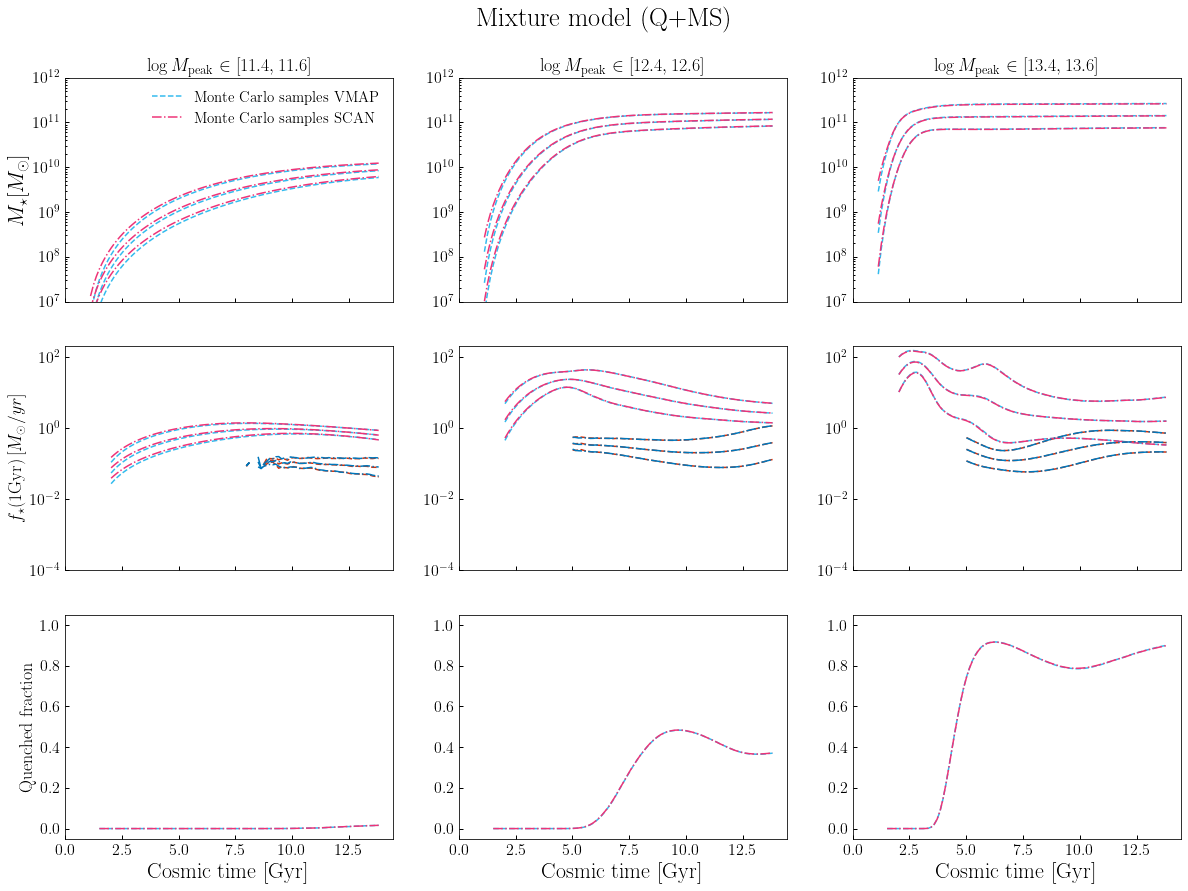

In [13]:
NM0 = len(logm0_binmids)


fontsize=22
fig, ax = plt.subplots(3,NM0, figsize=(20,14), sharex=True, sharey=False)

for i in range(NM0):

    ax[0,i].plot(t_table[sm_loss_sel], 10**_MC_res[0][i][sm_loss_sel], ls="--", color=colors[1], label='Monte Carlo samples VMAP')
    ax[0,i].plot(t_table[sm_loss_sel], 10**(_MC_res[0][i]-np.sqrt(_MC_res[1][i]))[sm_loss_sel], ls="--", color=colors[1],)
    ax[0,i].plot(t_table[sm_loss_sel], 10**(_MC_res[0][i]+np.sqrt(_MC_res[1][i]))[sm_loss_sel], ls="--", color=colors[1],)

    

    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**_MC_res[2][i][fstar_loss_MS_sel], ls="--", color=colors[1])
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(_MC_res[2][i]-np.sqrt(_MC_res[4][i]))[fstar_loss_MS_sel], ls="--", color=colors[1],)
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(_MC_res[2][i]+np.sqrt(_MC_res[4][i]))[fstar_loss_MS_sel], ls="--", color=colors[1],)

    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**_MC_res[3][i][fstar_loss_Q_sel], ls="--", color=colors[4])
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(_MC_res[3][i]-np.sqrt(_MC_res[5][i]))[fstar_loss_Q_sel], ls="--", color=colors[4],)
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(_MC_res[3][i]+np.sqrt(_MC_res[5][i]))[fstar_loss_Q_sel], ls="--", color=colors[4],)

    ax[2,i].plot(t_table[index_select], _MC_res[6][i], ls="--", color=colors[1])
    
    ax[0,i].plot(t_table[sm_loss_sel], 10**_MC_res_scan[0][i][sm_loss_sel], ls="-.", color=colors[5], label='Monte Carlo samples SCAN')
    ax[0,i].plot(t_table[sm_loss_sel], 10**(_MC_res_scan[0][i]-np.sqrt(_MC_res_scan[1][i]))[sm_loss_sel], ls="-.", color=colors[5],)
    ax[0,i].plot(t_table[sm_loss_sel], 10**(_MC_res_scan[0][i]+np.sqrt(_MC_res_scan[1][i]))[sm_loss_sel], ls="-.", color=colors[5],)

    

    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**_MC_res_scan[2][i][fstar_loss_MS_sel], ls="-.", color=colors[5])
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(_MC_res_scan[2][i]-np.sqrt(_MC_res_scan[4][i]))[fstar_loss_MS_sel], ls="-.", color=colors[5],)
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(_MC_res_scan[2][i]+np.sqrt(_MC_res_scan[4][i]))[fstar_loss_MS_sel], ls="-.", color=colors[5],)

    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**_MC_res_scan[3][i][fstar_loss_Q_sel], ls="-.", color=colors[0])
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(_MC_res_scan[3][i]-np.sqrt(_MC_res_scan[5][i]))[fstar_loss_Q_sel], ls="-.", color=colors[0],)
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(_MC_res_scan[3][i]+np.sqrt(_MC_res_scan[5][i]))[fstar_loss_Q_sel], ls="-.", color=colors[0],)

    ax[2,i].plot(t_table[index_select], _MC_res_scan[6][i], ls="-.", color=colors[5])
        

    
    ax[0,i].set_yscale('log')
    ax[1,i].set_yscale('log')
    ax[0,i].set_ylim(1e7, 1e12)
    ax[1,i].set_ylim(1e-4, 2e2)
    ax[2,i].set_ylim(-0.05,1.05)
    ax[2,i].set_xlabel('Cosmic time [Gyr]', fontsize=fontsize)
    ax[0,i].set_title(r'$\log M_{\rm peak}\in[%.1f, %.1f]$'%(logm0_binmids[i]-logm0_bin_widths[i], logm0_binmids[i]+logm0_bin_widths[i]))

ax[0,0].legend()
ax[1,0].legend()
ax[0,0].set_xticks(np.arange(0,13,2.5))
ax[0,0].set_ylabel('$M_\star [M_{\odot}]$', fontsize=fontsize)
ax[1,0].set_ylabel('$f_\star(1\mathrm{Gyr}) \,[M_{\odot}/yr]$')
ax[2,0].set_ylabel('Quenched fraction')
fig.suptitle("Mixture model (Q+MS)", y=0.95)
#fig.savefig('mc_vs_pdfweight_sumstats_MIX.png', bbox_inches='tight', dpi=300)


In [21]:
t_table.shape

(100,)

In [15]:
mah_params_diffmahpop.shape

(30, 6)

def weighted_avg_and_std(values, weights):
    
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    WSUM = 1.0/np.nansum(weights, axis=1)
    average = np.nansum(values * weights[:,:,None], axis=1) * WSUM[:, None]
    variance = np.nansum((values-average[:,None,:])**2 * weights[:,:,None], axis=1) * WSUM[:, None]
    return (average, variance)

def _get_MC_validation_quantities_full(N_mc_halos):

    
    mstar_MC = np.zeros((len(logm0_binmids), N_mc_halos, len(t_table)))
    sfr_MC = np.zeros((len(logm0_binmids), N_mc_halos, len(t_table)))
    fstar_MC = np.zeros((len(logm0_binmids), N_mc_halos, len(index_select)))
    weight_MC = np.zeros((len(logm0_binmids), N_mc_halos))

    _halo_sub_mask_indices = []

    for i in range(len(logm0_binmids)):
        #mask = (logmpeak_SMDPL>logm0_binmids[i]-logm0_bin_widths[i]) & (logmpeak_SMDPL<logm0_binmids[i]+logm0_bin_widths[i]) 
        #mask &= (sfh_params[:,5] < np.log10(TODAY))
        #mask = np.arange(len(logmpeak_SMDPL))[mask]#[:50]
        
        mask = (logmpeak_diffmahpop>logm0_binmids[i]-logm0_bin_widths[i]) & (logmpeak_diffmahpop<logm0_binmids[i]+logm0_bin_widths[i]) 
        mask = np.arange(len(logmpeak_diffmahpop))[np.array(mask)]#[:50]        
        
        _halo_sub_mask_indices.append(mask)
        
        _res = mc_sfh_population(
            jnp.log10(t_table),
            _get_dt_array(t_table),
            jnp.array([logm0_binmids[i]]),
            # mah_params_SMDPL[mask],
            mah_params_diffmahpop[mask],
            N_mc_halos,
            index_select,
            index_high,
            fstar_tdelay,
            seed=0,
            pdf_parameters_MS=DEFAULT_SFH_PDF_MAINSEQ_PARAMS,
            pdf_parameters_Q=DEFAULT_SFH_PDF_QUENCH_PARAMS
        )
            
        mstar_MC[i] = _res[0]
        sfr_MC[i] = _res[1]
        fstar_MC[i] = _res[2]
        weight_MC[i] = _res[3]

    sFstar = fstar_MC / mstar_MC[:, :, index_select]

    _halo_sub_mask_indices = np.concatenate(_halo_sub_mask_indices)
    _halo_sub_mask_indices.shape
    
    
    _MC_res = []
    _bla = weighted_avg_and_std(np.log10(mstar_MC), weight_MC)
    
    
    _MC_res.append( _bla[0] )
    _MC_res.append( _bla[1] )

    _dum = fstar_MC.copy()
    _dum[(sFstar<1e-11)] = np.nan
    _bla1 = weighted_avg_and_std(np.log10(_dum), weight_MC)
    _MC_res.append( _bla1[0] )

    _dum = fstar_MC.copy()
    _dum[(sFstar>1e-11)] = np.nan
    _bla2 = weighted_avg_and_std(np.log10(_dum), weight_MC)
    _MC_res.append( _bla2[0] )

    _dum = fstar_MC.copy()
    _dum[(sFstar<1e-11)] = np.nan
    _MC_res.append( _bla1[1] )

    _dum = fstar_MC.copy()
    _dum[(sFstar>1e-11)] = np.nan
    _MC_res.append( _bla2[1] )

    # breakpoint()
    _dum1 = np.ones_like(sFstar) * weight_MC[:,:,None]
    _dum1[(sFstar>1e-11)] = np.nan
    _dum2 = np.ones_like(sFstar) * weight_MC[:,:,None]
    _dum2[(sFstar<1e-11)] = np.nan
    
    _dum = np.nansum(_dum1,axis=1) / (np.nansum(_dum1,axis=1) + np.nansum(_dum2,axis=1))

    _MC_res.append( _dum )


    sm_mean_MC, sm_var_MC = _MC_res[0:2]
    fstar_mean_MS_MC, fstar_mean_Q_MC = _MC_res[2:4]
    fstar_var_MS_MC, fstar_var_Q_MC = _MC_res[4:6]
    quench_frac_MC = _MC_res[6]
    
    return _MC_res, _halo_sub_mask_indices, mstar_MC, sfr_MC

_MC_res, _halo_sub_mask_indices, mstar_MC, sfr_MC = _get_MC_validation_quantities_full(20000)




In [14]:
from diffstarpop.pdfmodel import (
    get_default_pdf_SFH_prediction_Q_diffstar_vmap_Xsfh_scan_Xmah_scan,
    get_default_pdf_SFH_prediction_Q_diffstar_scan_Xsfh_scan_Xmah_scan,
    get_default_pdf_SFH_prediction_Q_diffstar_scan_Xsfh_vmap_Xmah_vmap,
    get_default_pdf_SFH_prediction_MS_diffstar_vmap_Xsfh_scan_Xmah_scan,
    get_default_pdf_SFH_prediction_MS_diffstar_scan_Xsfh_scan_Xmah_scan,
    get_default_pdf_SFH_prediction_MS_diffstar_scan_Xsfh_vmap_Xmah_vmap,
    get_default_pdf_SFH_prediction_FULL_diffstar_vmap_Xsfh_scan_Xmah_scan,
    get_default_pdf_SFH_prediction_FULL_diffstar_scan_Xsfh_scan_Xmah_scan,
    get_default_pdf_SFH_prediction_FULL_diffstar_scan_Xsfh_vmap_Xmah_vmap,

)
import jax.random as jax_ran

halo_data_validation = mah_params_diffmahpop[:, np.array([1,2,4,5])].T.copy()
halo_data_validation[1] = 10**halo_data_validation[1]


In [17]:
n_halos_per_bin = 10

seed = 1291
jran_key = jax_ran.PRNGKey(seed=seed)
sfh_lh_sig = 3.0
n_sfh_param_grid = int(1e5)

t0 = time.time()
_target_res = get_default_pdf_SFH_prediction_FULL_diffstar_vmap_Xsfh_scan_Xmah_scan(
    sfh_lh_sig,
    t_table,
    n_sfh_param_grid,
    logm0_binmids,
    logm0_bin_widths,
    n_halos_per_bin,
    halo_data_validation,
    fstar_tdelay,
    DEFAULT_SFH_PDF_MAINSEQ_PARAMS,
    DEFAULT_SFH_PDF_QUENCH_PARAMS,
)
t1 = time.time()
print(t1-t0)

131.33912682533264


In [23]:
n_halos_per_bin = 10

seed = 1291
jran_key = jax_ran.PRNGKey(seed=seed)
sfh_lh_sig = 3.0
n_sfh_param_grid = int(1e5)


t0 = time.time()
_target_res_Q = get_default_pdf_SFH_prediction_Q_diffstar_vmap_Xsfh_scan_Xmah_scan(
    sfh_lh_sig,
    t_table,
    n_sfh_param_grid,
    logm0_binmids,
    logm0_bin_widths,
    n_halos_per_bin,
    halo_data_validation,
    fstar_tdelay,
    DEFAULT_SFH_PDF_QUENCH_PARAMS
)
t1 = time.time()
print(t1-t0)

44.00564980506897


In [19]:
n_halos_per_bin = 10

seed = 1291
jran_key = jax_ran.PRNGKey(seed=seed)
sfh_lh_sig = 3.0
n_sfh_param_grid = int(1e5)


t0 = time.time()
_target_res_MS = get_default_pdf_SFH_prediction_MS_diffstar_vmap_Xsfh_scan_Xmah_scan(
    sfh_lh_sig,
    t_table,
    n_sfh_param_grid,
    logm0_binmids,
    logm0_bin_widths,
    n_halos_per_bin,
    halo_data_validation,
    fstar_tdelay,
    DEFAULT_SFH_PDF_MAINSEQ_PARAMS
)
t1 = time.time()
print(t1-t0)

47.33339500427246


In [64]:
from diffstarpop.pdf_diffmah import get_binned_halo_sample
halo_data_validation = mah_params_diffmahpop[:, np.array([1,2,4,5])].T.copy()
halo_data_validation[1] = 10**halo_data_validation[1]

logm0_halos, mah_tauc_halos, mah_early_halos, mah_late_halos = halo_data_validation
diffmah_params_grid = get_binned_halo_sample(
        n_halos_per_bin,
        jran_key,
        logm0_binmids,
        logm0_bin_widths,
        logm0_halos,
        mah_tauc_halos,
        mah_early_halos,
        mah_late_halos,
    )

diffmah_params_grid = np.array(diffmah_params_grid)
diffmah_params_grid = diffmah_params_grid.reshape(
    (4, len(logm0_binmids), n_halos_per_bin)
)
diffmah_params_grid = np.einsum("pmh->mhp", diffmah_params_grid)


In [28]:
n_halos_per_bin = 10

seed = 1291
jran_key = jax_ran.PRNGKey(seed=seed)
sfh_lh_sig = 3.0
n_sfh_param_grid = int(1e4)

t0 = time.time()
_target_res_Q_scan = get_default_pdf_SFH_prediction_Q_diffstar_scan_Xsfh_scan_Xmah_scan(
    sfh_lh_sig,
    t_table,
    n_sfh_param_grid,
    logm0_binmids,
    logm0_bin_widths,
    n_halos_per_bin,
    halo_data_validation,
    fstar_tdelay,
    DEFAULT_SFH_PDF_QUENCH_PARAMS
)
t1 = time.time()
print(t1-t0)


118.61012101173401


In [30]:
n_halos_per_bin = 10

seed = 1291
jran_key = jax_ran.PRNGKey(seed=seed)
sfh_lh_sig = 3.0
n_sfh_param_grid = int(1e5)

t0 = time.time()
_target_res_Q_scan_vmap = get_default_pdf_SFH_prediction_Q_diffstar_scan_Xsfh_vmap_Xmah_vmap(
    sfh_lh_sig,
    t_table,
    n_sfh_param_grid,
    logm0_binmids,
    logm0_bin_widths,
    n_halos_per_bin,
    halo_data_validation,
    fstar_tdelay,
    DEFAULT_SFH_PDF_QUENCH_PARAMS
)
t1 = time.time()
print(t1-t0)

109.99970817565918


In [14]:
n_halos_per_bin = 10

seed = 1291
jran_key = jax_ran.PRNGKey(seed=seed)
sfh_lh_sig = 3.0
n_sfh_param_grid = int(1e4)

t0 = time.time()
_target_res_MS_scan = get_default_pdf_SFH_prediction_MS_diffstar_scan_Xsfh_scan_Xmah_scan(
    sfh_lh_sig,
    t_table,
    n_sfh_param_grid,
    logm0_binmids,
    logm0_bin_widths,
    n_halos_per_bin,
    halo_data_validation,
    fstar_tdelay,
    DEFAULT_SFH_PDF_MAINSEQ_PARAMS
)
t1 = time.time()
print(t1-t0)


111.755136013031


In [16]:
n_halos_per_bin = 10

seed = 1291
jran_key = jax_ran.PRNGKey(seed=seed)
sfh_lh_sig = 3.0
n_sfh_param_grid = int(1e4)

t0 = time.time()
_target_res_MS_scan_vmap = get_default_pdf_SFH_prediction_MS_diffstar_scan_Xsfh_vmap_Xmah_vmap(
    sfh_lh_sig,
    t_table,
    n_sfh_param_grid,
    logm0_binmids,
    logm0_bin_widths,
    n_halos_per_bin,
    halo_data_validation,
    fstar_tdelay,
    DEFAULT_SFH_PDF_MAINSEQ_PARAMS
)
t1 = time.time()
print(t1-t0)

12.593369722366333


In [18]:
n_halos_per_bin = 10

seed = 1291
jran_key = jax_ran.PRNGKey(seed=seed)
sfh_lh_sig = 3.0
n_sfh_param_grid = int(1e4)

t0 = time.time()
_target_res_scan = get_default_pdf_SFH_prediction_FULL_diffstar_scan_Xsfh_scan_Xmah_scan(
    sfh_lh_sig,
    t_table,
    n_sfh_param_grid,
    logm0_binmids,
    logm0_bin_widths,
    n_halos_per_bin,
    halo_data_validation,
    fstar_tdelay,
    DEFAULT_SFH_PDF_MAINSEQ_PARAMS,
    DEFAULT_SFH_PDF_QUENCH_PARAMS,
)
t1 = time.time()
print(t1-t0)

211.97243905067444


In [19]:
n_halos_per_bin = 10

seed = 1291
jran_key = jax_ran.PRNGKey(seed=seed)
sfh_lh_sig = 3.0
n_sfh_param_grid = int(1e5)

t0 = time.time()
_target_res_scan_vmap = get_default_pdf_SFH_prediction_FULL_diffstar_scan_Xsfh_vmap_Xmah_vmap(
    sfh_lh_sig,
    t_table,
    n_sfh_param_grid,
    logm0_binmids,
    logm0_bin_widths,
    n_halos_per_bin,
    halo_data_validation,
    fstar_tdelay,
    DEFAULT_SFH_PDF_MAINSEQ_PARAMS,
    DEFAULT_SFH_PDF_QUENCH_PARAMS,
)
t1 = time.time()
print(t1-t0)

218.76145720481873


In [15]:
_target_res_scan

(DeviceArray([[ 6.434691 ,  6.8156075,  7.065735 ,  7.2591386,  7.4193873,
                7.55727  ,  7.6787553,  7.787561 ,  7.886201 ,  7.976458 ,
                8.05966  ,  8.136835 ,  8.208799 ,  8.276195 ,  8.339551 ,
                8.3993225,  8.45587  ,  8.509506 ,  8.560517 ,  8.6091175,
                8.655513 ,  8.699886 ,  8.742383 ,  8.783149 ,  8.822303 ,
                8.859947 ,  8.896186 ,  8.931103 ,  8.964779 ,  8.997282 ,
                9.028686 ,  9.059037 ,  9.088398 ,  9.116814 ,  9.144331 ,
                9.170995 ,  9.196837 ,  9.2219   ,  9.24621  ,  9.269805 ,
                9.292708 ,  9.314953 ,  9.336563 ,  9.357548 ,  9.377944 ,
                9.397767 ,  9.417045 ,  9.435782 ,  9.454017 ,  9.471742 ,
                9.488992 ,  9.505771 ,  9.522098 ,  9.537971 ,  9.553398 ,
                9.568408 ,  9.583013 ,  9.597231 ,  9.61106  ,  9.62452  ,
                9.637613 ,  9.650373 ,  9.662795 ,  9.674891 ,  9.68666  ,
                9.6981125

In [32]:
mstar_data_Q = np.zeros((len(logm0_binmids), len(SMDPL_t)))
mstar_data_MS = np.zeros((len(logm0_binmids), len(SMDPL_t)))

for i in range(len(logm0_binmids)):
    mask = (logmpeak_SMDPL>logm0_binmids[i]-logm0_bin_widths[i]) & (logmpeak_SMDPL<logm0_binmids[i]+logm0_bin_widths[i]) 
    mask1 = mask&(sfh_params[:,5] < np.log10(TODAY))
    mask2 = mask&(sfh_params[:,5] > np.log10(TODAY))
    
    _dum = np.where(sm_cumsum_SMDPL[mask1] > 0.0, np.log10(sm_cumsum_SMDPL[mask1]), np.nan)
    mstar_data_Q[i] = np.nanmean(_dum, axis=0)
    _dum = np.where(sm_cumsum_SMDPL[mask2] > 0.0, np.log10(sm_cumsum_SMDPL[mask2]), np.nan)
    mstar_data_MS[i] = np.nanmean(_dum, axis=0)
    # mstar_data[i] = np.log10(np.nanmean(sm_cumsum_SMDPL[mask], axis=0))
    # mstar_data_Q[i] = np.log10(np.nanmean(sm_cumsum_SMDPL[mask1], axis=0))
    # mstar_data_MS[i] = np.log10(np.nanmean(sm_cumsum_SMDPL[mask2], axis=0))
    

/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':


Text(0.5, 0.95, 'Quenched model')

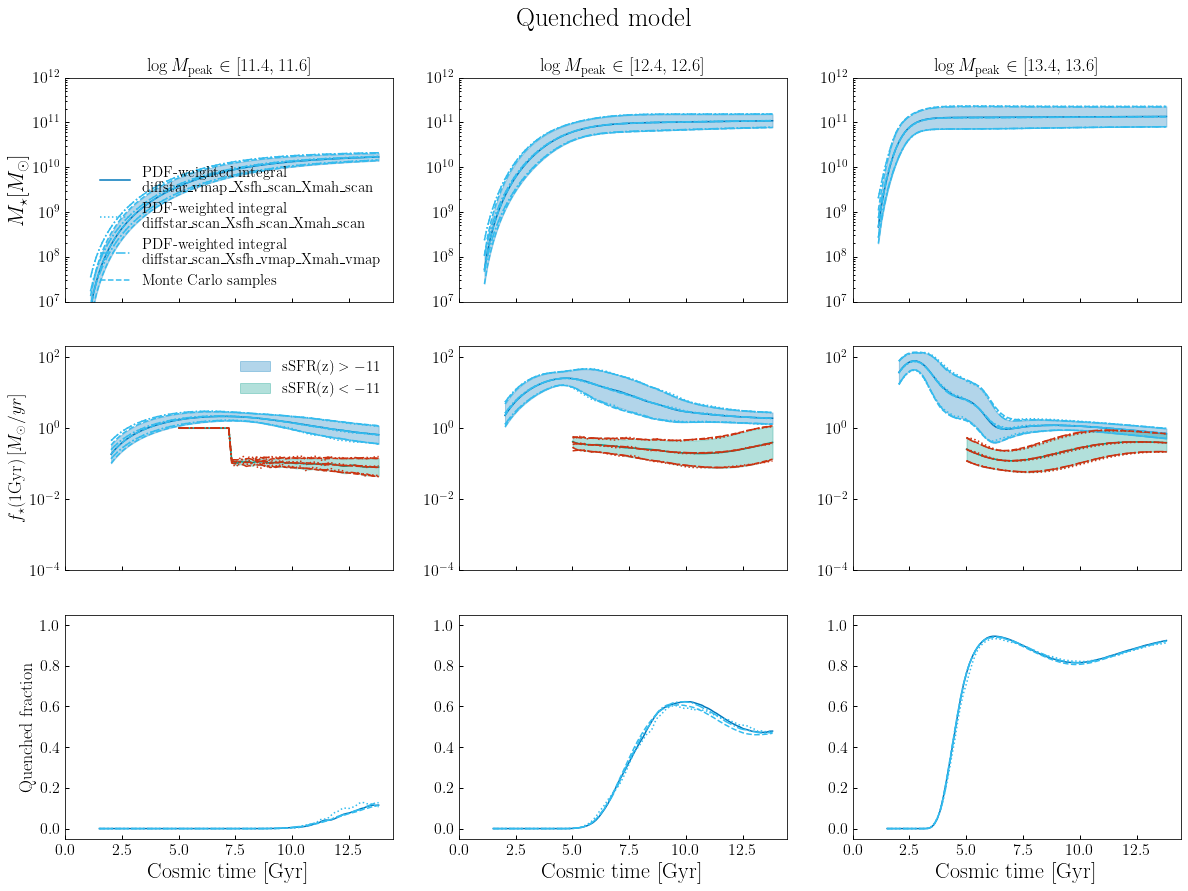

In [33]:
NM0 = len(logm0_binmids)


fontsize=22
fig, ax = plt.subplots(3,NM0, figsize=(20,14), sharex=True, sharey=False)

for i in range(NM0):
    #"""
    ax[0,i].plot(t_table[sm_loss_sel], 10**_target_res_Q[0][i][sm_loss_sel], color=colors[0], label='PDF-weighted integral\n'+'diffstar\_vmap\_Xsfh\_scan\_Xmah\_scan')
    ax[0,i].fill_between(t_table[sm_loss_sel], 
                       10**(_target_res_Q[0][i]-np.sqrt(_target_res_Q[1][i]))[sm_loss_sel],
                       10**(_target_res_Q[0][i]+np.sqrt(_target_res_Q[1][i]))[sm_loss_sel],
                       color=colors[0],
                       alpha = 0.3         
                      )
    

    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**_target_res_Q[2][i][fstar_loss_MS_sel], color=colors[0])
    ax[1,i].fill_between(t_table[index_select][fstar_loss_MS_sel], 
                       10**(_target_res_Q[2][i]-np.sqrt(_target_res_Q[4][i]))[fstar_loss_MS_sel],
                       10**(_target_res_Q[2][i]+np.sqrt(_target_res_Q[4][i]))[fstar_loss_MS_sel],
                       color=colors[0],
                       alpha = 0.3, label = r"$\rm{sSFR}(z) > -11$"         
                      )
    
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**_target_res_Q[3][i][fstar_loss_Q_sel], color=colors[2])
    ax[1,i].fill_between(t_table[index_select][fstar_loss_Q_sel], 
                       10**(_target_res_Q[3][i]-np.sqrt(_target_res_Q[5][i]))[fstar_loss_Q_sel],
                       10**(_target_res_Q[3][i]+np.sqrt(_target_res_Q[5][i]))[fstar_loss_Q_sel],
                       color=colors[2],
                       alpha = 0.3, label = r"$\rm{sSFR}(z) < -11$"      
                      )
                      
    ax[2,i].plot(t_table[index_select], _target_res_Q[6][i], color=colors[0])
    
    
    
    ax[0,i].plot(t_table[sm_loss_sel], 10**_target_res_Q_scan[0][i][sm_loss_sel], ls=":", color=colors[1], label='PDF-weighted integral\n'+'diffstar\_scan\_Xsfh\_scan\_Xmah\_scan')
    ax[0,i].plot(t_table[sm_loss_sel], 10**(_target_res_Q_scan[0][i]-np.sqrt(_target_res_Q_scan[1][i]))[sm_loss_sel], ls=":", color=colors[1],)
    ax[0,i].plot(t_table[sm_loss_sel], 10**(_target_res_Q_scan[0][i]+np.sqrt(_target_res_Q_scan[1][i]))[sm_loss_sel], ls=":", color=colors[1],)

    

    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**_target_res_Q_scan[2][i][fstar_loss_MS_sel], ls=":", color=colors[1])
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(_target_res_Q_scan[2][i]-np.sqrt(_target_res_Q_scan[4][i]))[fstar_loss_MS_sel], ls=":", color=colors[1],)
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(_target_res_Q_scan[2][i]+np.sqrt(_target_res_Q_scan[4][i]))[fstar_loss_MS_sel], ls=":", color=colors[1],)

    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**_target_res_Q_scan[3][i][fstar_loss_Q_sel], ls=":", color=colors[4])
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(_target_res_Q_scan[3][i]-np.sqrt(_target_res_Q_scan[5][i]))[fstar_loss_Q_sel], ls=":", color=colors[4],)
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(_target_res_Q_scan[3][i]+np.sqrt(_target_res_Q_scan[5][i]))[fstar_loss_Q_sel], ls=":", color=colors[4],)

    ax[2,i].plot(t_table[index_select], _target_res_Q_scan[6][i], ls=":", color=colors[1])
    
    ax[0,i].plot(t_table[sm_loss_sel], 10**_target_res_Q_scan_vmap[0][i][sm_loss_sel], ls="-.", color=colors[1], label='PDF-weighted integral\n'+'diffstar\_scan\_Xsfh\_vmap\_Xmah\_vmap')
    ax[0,i].plot(t_table[sm_loss_sel], 10**(_target_res_Q_scan_vmap[0][i]-np.sqrt(_target_res_Q_scan_vmap[1][i]))[sm_loss_sel], ls="-.", color=colors[1],)
    ax[0,i].plot(t_table[sm_loss_sel], 10**(_target_res_Q_scan_vmap[0][i]+np.sqrt(_target_res_Q_scan_vmap[1][i]))[sm_loss_sel], ls="-.", color=colors[1],)

    

    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**_target_res_Q_scan_vmap[2][i][fstar_loss_MS_sel], ls="-.", color=colors[1])
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(_target_res_Q_scan_vmap[2][i]-np.sqrt(_target_res_Q_scan_vmap[4][i]))[fstar_loss_MS_sel], ls="-.", color=colors[1],)
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(_target_res_Q_scan_vmap[2][i]+np.sqrt(_target_res_Q_scan_vmap[4][i]))[fstar_loss_MS_sel], ls="-.", color=colors[1],)

    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**_target_res_Q_scan_vmap[3][i][fstar_loss_Q_sel], ls="-.", color=colors[4])
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(_target_res_Q_scan_vmap[3][i]-np.sqrt(_target_res_Q_scan_vmap[5][i]))[fstar_loss_Q_sel], ls="-.", color=colors[4],)
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(_target_res_Q_scan_vmap[3][i]+np.sqrt(_target_res_Q_scan_vmap[5][i]))[fstar_loss_Q_sel], ls="-.", color=colors[4],)

    ax[2,i].plot(t_table[index_select], _target_res_Q_scan_vmap[6][i], ls="-.", color=colors[1])

    #"""
    ax[0,i].plot(t_table[sm_loss_sel], 10**_MC_res_Q[0][i][sm_loss_sel], ls="--", color=colors[1], label='Monte Carlo samples')
    ax[0,i].plot(t_table[sm_loss_sel], 10**(_MC_res_Q[0][i]-np.sqrt(_MC_res_Q[1][i]))[sm_loss_sel], ls="--", color=colors[1],)
    ax[0,i].plot(t_table[sm_loss_sel], 10**(_MC_res_Q[0][i]+np.sqrt(_MC_res_Q[1][i]))[sm_loss_sel], ls="--", color=colors[1],)

    

    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**_MC_res_Q[2][i][fstar_loss_MS_sel], ls="--", color=colors[1])
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(_MC_res_Q[2][i]-np.sqrt(_MC_res_Q[4][i]))[fstar_loss_MS_sel], ls="--", color=colors[1],)
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(_MC_res_Q[2][i]+np.sqrt(_MC_res_Q[4][i]))[fstar_loss_MS_sel], ls="--", color=colors[1],)

    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**_MC_res_Q[3][i][fstar_loss_Q_sel], ls="--", color=colors[4])
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(_MC_res_Q[3][i]-np.sqrt(_MC_res_Q[5][i]))[fstar_loss_Q_sel], ls="--", color=colors[4],)
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(_MC_res_Q[3][i]+np.sqrt(_MC_res_Q[5][i]))[fstar_loss_Q_sel], ls="--", color=colors[4],)

    ax[2,i].plot(t_table[index_select], _MC_res_Q[6][i], ls="--", color=colors[1])
    

    
    #ax[0,i].plot(SMDPL_t, 10**mstar_data_Q[i], ls="-.", color='k', lw = 2, label='Data')

    
    ax[0,i].set_yscale('log')
    ax[1,i].set_yscale('log')
    ax[0,i].set_ylim(1e7, 1e12)
    ax[1,i].set_ylim(1e-4, 2e2)
    ax[2,i].set_ylim(-0.05,1.05)
    ax[2,i].set_xlabel('Cosmic time [Gyr]', fontsize=fontsize)
    ax[0,i].set_title(r'$\log M_{\rm peak}\in[%.1f, %.1f]$'%(logm0_binmids[i]-logm0_bin_widths[i], logm0_binmids[i]+logm0_bin_widths[i]))

ax[0,0].legend()
ax[1,0].legend()
ax[0,0].set_xticks(np.arange(0,13,2.5))
ax[0,0].set_ylabel('$M_\star [M_{\odot}]$', fontsize=fontsize)
ax[1,0].set_ylabel('$f_\star(1\mathrm{Gyr}) \,[M_{\odot}/yr]$')
ax[2,0].set_ylabel('Quenched fraction')
fig.suptitle("Quenched model", y=0.95)
#fig.savefig('mc_vs_pdfweight_sumstats_Q.png', bbox_inches='tight', dpi=300)


Text(0.5, 0.95, 'Quenched model')

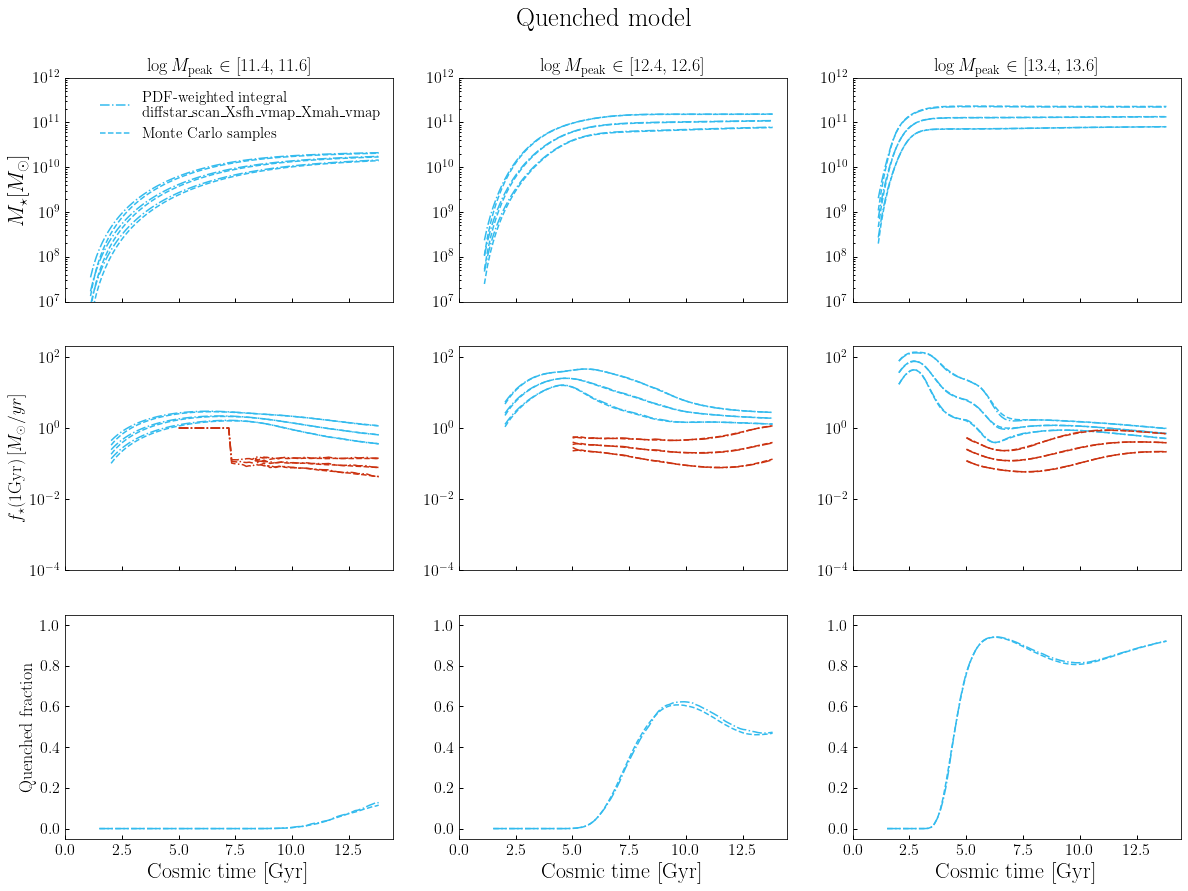

In [34]:
NM0 = len(logm0_binmids)


fontsize=22
fig, ax = plt.subplots(3,NM0, figsize=(20,14), sharex=True, sharey=False)

for i in range(NM0):

    ax[0,i].plot(t_table[sm_loss_sel], 10**_target_res_Q_scan_vmap[0][i][sm_loss_sel], ls="-.", color=colors[1], label='PDF-weighted integral\n'+'diffstar\_scan\_Xsfh\_vmap\_Xmah\_vmap')
    ax[0,i].plot(t_table[sm_loss_sel], 10**(_target_res_Q_scan_vmap[0][i]-np.sqrt(_target_res_Q_scan_vmap[1][i]))[sm_loss_sel], ls="-.", color=colors[1],)
    ax[0,i].plot(t_table[sm_loss_sel], 10**(_target_res_Q_scan_vmap[0][i]+np.sqrt(_target_res_Q_scan_vmap[1][i]))[sm_loss_sel], ls="-.", color=colors[1],)

    

    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**_target_res_Q_scan_vmap[2][i][fstar_loss_MS_sel], ls="-.", color=colors[1])
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(_target_res_Q_scan_vmap[2][i]-np.sqrt(_target_res_Q_scan_vmap[4][i]))[fstar_loss_MS_sel], ls="-.", color=colors[1],)
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(_target_res_Q_scan_vmap[2][i]+np.sqrt(_target_res_Q_scan_vmap[4][i]))[fstar_loss_MS_sel], ls="-.", color=colors[1],)

    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**_target_res_Q_scan_vmap[3][i][fstar_loss_Q_sel], ls="-.", color=colors[4])
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(_target_res_Q_scan_vmap[3][i]-np.sqrt(_target_res_Q_scan_vmap[5][i]))[fstar_loss_Q_sel], ls="-.", color=colors[4],)
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(_target_res_Q_scan_vmap[3][i]+np.sqrt(_target_res_Q_scan_vmap[5][i]))[fstar_loss_Q_sel], ls="-.", color=colors[4],)

    ax[2,i].plot(t_table[index_select], _target_res_Q_scan_vmap[6][i], ls="-.", color=colors[1])

    #"""
    ax[0,i].plot(t_table[sm_loss_sel], 10**_MC_res_Q[0][i][sm_loss_sel], ls="--", color=colors[1], label='Monte Carlo samples')
    ax[0,i].plot(t_table[sm_loss_sel], 10**(_MC_res_Q[0][i]-np.sqrt(_MC_res_Q[1][i]))[sm_loss_sel], ls="--", color=colors[1],)
    ax[0,i].plot(t_table[sm_loss_sel], 10**(_MC_res_Q[0][i]+np.sqrt(_MC_res_Q[1][i]))[sm_loss_sel], ls="--", color=colors[1],)

    

    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**_MC_res_Q[2][i][fstar_loss_MS_sel], ls="--", color=colors[1])
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(_MC_res_Q[2][i]-np.sqrt(_MC_res_Q[4][i]))[fstar_loss_MS_sel], ls="--", color=colors[1],)
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(_MC_res_Q[2][i]+np.sqrt(_MC_res_Q[4][i]))[fstar_loss_MS_sel], ls="--", color=colors[1],)

    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**_MC_res_Q[3][i][fstar_loss_Q_sel], ls="--", color=colors[4])
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(_MC_res_Q[3][i]-np.sqrt(_MC_res_Q[5][i]))[fstar_loss_Q_sel], ls="--", color=colors[4],)
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(_MC_res_Q[3][i]+np.sqrt(_MC_res_Q[5][i]))[fstar_loss_Q_sel], ls="--", color=colors[4],)

    ax[2,i].plot(t_table[index_select], _MC_res_Q[6][i], ls="--", color=colors[1])
    

    
    #ax[0,i].plot(SMDPL_t, 10**mstar_data_Q[i], ls="-.", color='k', lw = 2, label='Data')

    
    ax[0,i].set_yscale('log')
    ax[1,i].set_yscale('log')
    ax[0,i].set_ylim(1e7, 1e12)
    ax[1,i].set_ylim(1e-4, 2e2)
    ax[2,i].set_ylim(-0.05,1.05)
    ax[2,i].set_xlabel('Cosmic time [Gyr]', fontsize=fontsize)
    ax[0,i].set_title(r'$\log M_{\rm peak}\in[%.1f, %.1f]$'%(logm0_binmids[i]-logm0_bin_widths[i], logm0_binmids[i]+logm0_bin_widths[i]))

ax[0,0].legend()
ax[1,0].legend()
ax[0,0].set_xticks(np.arange(0,13,2.5))
ax[0,0].set_ylabel('$M_\star [M_{\odot}]$', fontsize=fontsize)
ax[1,0].set_ylabel('$f_\star(1\mathrm{Gyr}) \,[M_{\odot}/yr]$')
ax[2,0].set_ylabel('Quenched fraction')
fig.suptitle("Quenched model", y=0.95)
#fig.savefig('mc_vs_pdfweight_sumstats_Q.png', bbox_inches='tight', dpi=300)


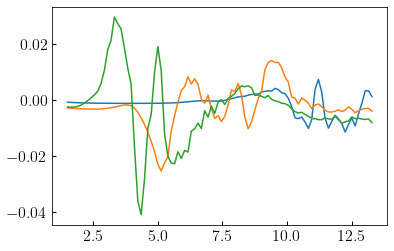

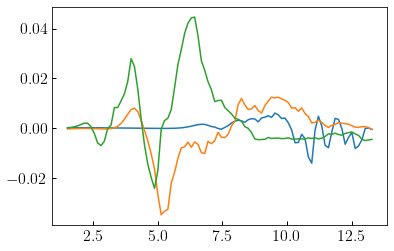

In [21]:
for i in range(3):
    plt.plot(t_table[fstar_loss_MS_sel], _target_res_Q[2][i][fstar_loss_MS_sel]-_MC_res_Q[2][i][fstar_loss_MS_sel])
plt.show()
for i in range(3):
    plt.plot(t_table[fstar_loss_MS_sel], np.sqrt(_MC_res_Q[4][i])[fstar_loss_MS_sel]-np.sqrt(_target_res_Q[4][i])[fstar_loss_MS_sel])
plt.show()

Text(0.5, 0.95, 'Main Sequence model')

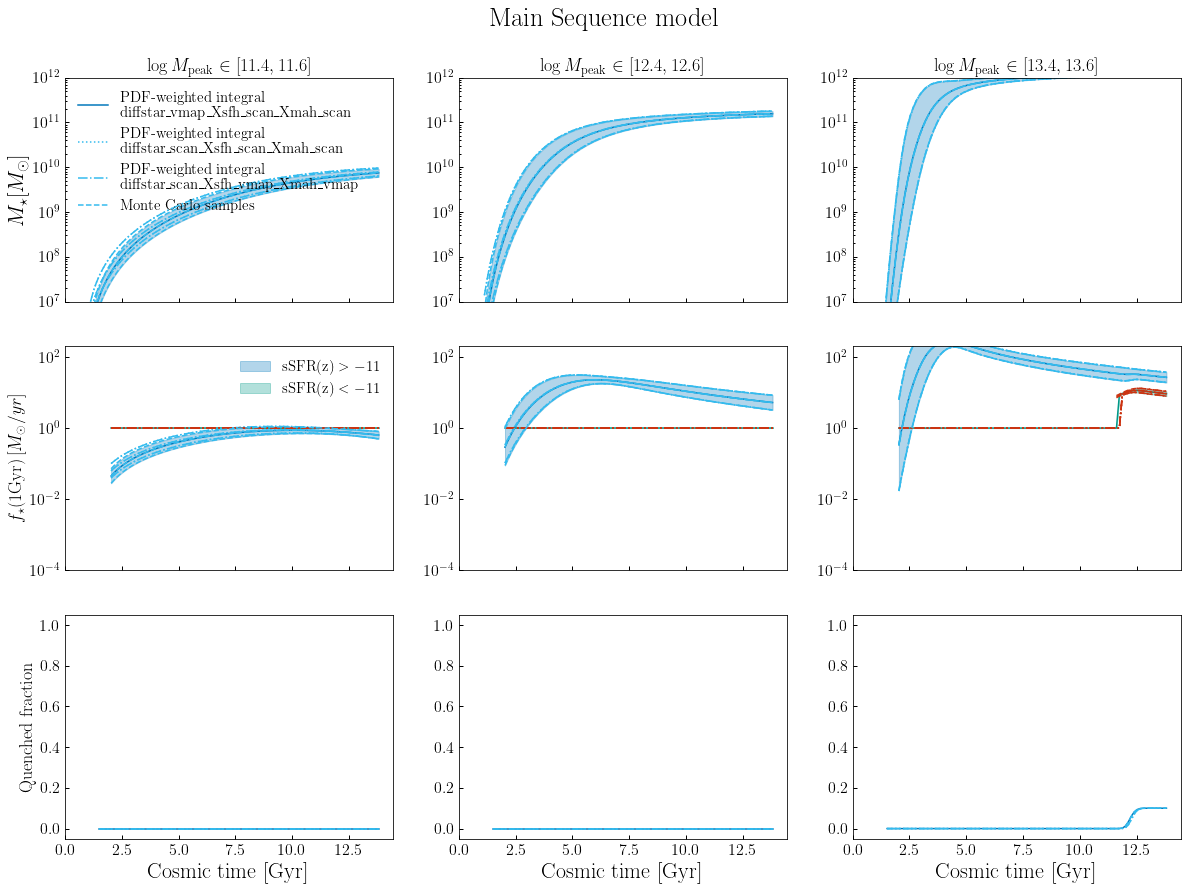

In [21]:
NM0 = len(logm0_binmids)


fontsize=22
fig, ax = plt.subplots(3,NM0, figsize=(20,14), sharex=True, sharey=False)

for i in range(NM0):
    #"""
    ax[0,i].plot(t_table[sm_loss_sel], 10**_target_res_MS[0][i][sm_loss_sel], color=colors[0], label='PDF-weighted integral\n'+'diffstar\_vmap\_Xsfh\_scan\_Xmah\_scan')
    ax[0,i].fill_between(t_table[sm_loss_sel], 
                       10**(_target_res_MS[0][i]-np.sqrt(_target_res_MS[1][i]))[sm_loss_sel],
                       10**(_target_res_MS[0][i]+np.sqrt(_target_res_MS[1][i]))[sm_loss_sel],
                       color=colors[0],
                       alpha = 0.3         
                      )
    

    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**_target_res_MS[2][i][fstar_loss_MS_sel], color=colors[0])
    ax[1,i].fill_between(t_table[index_select][fstar_loss_MS_sel], 
                       10**(_target_res_MS[2][i]-np.sqrt(_target_res_MS[4][i]))[fstar_loss_MS_sel],
                       10**(_target_res_MS[2][i]+np.sqrt(_target_res_MS[4][i]))[fstar_loss_MS_sel],
                       color=colors[0],
                       alpha = 0.3, label = r"$\rm{sSFR}(z) > -11$"         
                      )
    
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**_target_res_MS[3][i][fstar_loss_Q_sel], color=colors[2])
    ax[1,i].fill_between(t_table[index_select][fstar_loss_Q_sel], 
                       10**(_target_res_MS[3][i]-np.sqrt(_target_res_MS[5][i]))[fstar_loss_Q_sel],
                       10**(_target_res_MS[3][i]+np.sqrt(_target_res_MS[5][i]))[fstar_loss_Q_sel],
                       color=colors[2],
                       alpha = 0.3, label = r"$\rm{sSFR}(z) < -11$"      
                      )
                      
    ax[2,i].plot(t_table[index_select], _target_res_MS[6][i], color=colors[0])
    
    
    
    ax[0,i].plot(t_table[sm_loss_sel], 10**_target_res_MS_scan[0][i][sm_loss_sel], ls=":", color=colors[1], label='PDF-weighted integral\n'+'diffstar\_scan\_Xsfh\_scan\_Xmah\_scan')
    ax[0,i].plot(t_table[sm_loss_sel], 10**(_target_res_MS_scan[0][i]-np.sqrt(_target_res_MS_scan[1][i]))[sm_loss_sel], ls=":", color=colors[1],)
    ax[0,i].plot(t_table[sm_loss_sel], 10**(_target_res_MS_scan[0][i]+np.sqrt(_target_res_MS_scan[1][i]))[sm_loss_sel], ls=":", color=colors[1],)

    

    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**_target_res_MS_scan[2][i][fstar_loss_MS_sel], ls=":", color=colors[1])
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(_target_res_MS_scan[2][i]-np.sqrt(_target_res_MS_scan[4][i]))[fstar_loss_MS_sel], ls=":", color=colors[1],)
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(_target_res_MS_scan[2][i]+np.sqrt(_target_res_MS_scan[4][i]))[fstar_loss_MS_sel], ls=":", color=colors[1],)

    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**_target_res_MS_scan[3][i][fstar_loss_Q_sel], ls=":", color=colors[4])
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(_target_res_MS_scan[3][i]-np.sqrt(_target_res_MS_scan[5][i]))[fstar_loss_Q_sel], ls=":", color=colors[4],)
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(_target_res_MS_scan[3][i]+np.sqrt(_target_res_MS_scan[5][i]))[fstar_loss_Q_sel], ls=":", color=colors[4],)

    ax[2,i].plot(t_table[index_select], _target_res_MS_scan[6][i], ls=":", color=colors[1])
    
    ax[0,i].plot(t_table[sm_loss_sel], 10**_target_res_MS_scan_vmap[0][i][sm_loss_sel], ls="-.", color=colors[1], label='PDF-weighted integral\n'+'diffstar\_scan\_Xsfh\_vmap\_Xmah\_vmap')
    ax[0,i].plot(t_table[sm_loss_sel], 10**(_target_res_MS_scan_vmap[0][i]-np.sqrt(_target_res_MS_scan_vmap[1][i]))[sm_loss_sel], ls="-.", color=colors[1],)
    ax[0,i].plot(t_table[sm_loss_sel], 10**(_target_res_MS_scan_vmap[0][i]+np.sqrt(_target_res_MS_scan_vmap[1][i]))[sm_loss_sel], ls="-.", color=colors[1],)

    

    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**_target_res_MS_scan_vmap[2][i][fstar_loss_MS_sel], ls="-.", color=colors[1])
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(_target_res_MS_scan_vmap[2][i]-np.sqrt(_target_res_MS_scan_vmap[4][i]))[fstar_loss_MS_sel], ls="-.", color=colors[1],)
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(_target_res_MS_scan_vmap[2][i]+np.sqrt(_target_res_MS_scan_vmap[4][i]))[fstar_loss_MS_sel], ls="-.", color=colors[1],)

    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**_target_res_MS_scan_vmap[3][i][fstar_loss_Q_sel], ls="-.", color=colors[4])
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(_target_res_MS_scan_vmap[3][i]-np.sqrt(_target_res_MS_scan_vmap[5][i]))[fstar_loss_Q_sel], ls="-.", color=colors[4],)
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(_target_res_MS_scan_vmap[3][i]+np.sqrt(_target_res_MS_scan_vmap[5][i]))[fstar_loss_Q_sel], ls="-.", color=colors[4],)

    ax[2,i].plot(t_table[index_select], _target_res_MS_scan_vmap[6][i], ls="-.", color=colors[1])

    #"""
    ax[0,i].plot(t_table[sm_loss_sel], 10**_MC_res_MS[0][i][sm_loss_sel], ls="--", color=colors[1], label='Monte Carlo samples')
    ax[0,i].plot(t_table[sm_loss_sel], 10**(_MC_res_MS[0][i]-np.sqrt(_MC_res_MS[1][i]))[sm_loss_sel], ls="--", color=colors[1],)
    ax[0,i].plot(t_table[sm_loss_sel], 10**(_MC_res_MS[0][i]+np.sqrt(_MC_res_MS[1][i]))[sm_loss_sel], ls="--", color=colors[1],)

    

    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**_MC_res_MS[2][i][fstar_loss_MS_sel], ls="--", color=colors[1])
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(_MC_res_MS[2][i]-np.sqrt(_MC_res_MS[4][i]))[fstar_loss_MS_sel], ls="--", color=colors[1],)
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(_MC_res_MS[2][i]+np.sqrt(_MC_res_MS[4][i]))[fstar_loss_MS_sel], ls="--", color=colors[1],)

    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**_MC_res_MS[3][i][fstar_loss_Q_sel], ls="--", color=colors[4])
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(_MC_res_MS[3][i]-np.sqrt(_MC_res_MS[5][i]))[fstar_loss_Q_sel], ls="--", color=colors[4],)
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(_MC_res_MS[3][i]+np.sqrt(_MC_res_MS[5][i]))[fstar_loss_Q_sel], ls="--", color=colors[4],)

    ax[2,i].plot(t_table[index_select], _MC_res_MS[6][i], ls="--", color=colors[1])
    


    
    ax[0,i].set_yscale('log')
    ax[1,i].set_yscale('log')
    ax[0,i].set_ylim(1e7, 1e12)
    ax[1,i].set_ylim(1e-4, 2e2)
    ax[2,i].set_ylim(-0.05,1.05)
    ax[2,i].set_xlabel('Cosmic time [Gyr]', fontsize=fontsize)
    ax[0,i].set_title(r'$\log M_{\rm peak}\in[%.1f, %.1f]$'%(logm0_binmids[i]-logm0_bin_widths[i], logm0_binmids[i]+logm0_bin_widths[i]))

ax[0,0].legend()
ax[1,0].legend()
ax[0,0].set_xticks(np.arange(0,13,2.5))
ax[0,0].set_ylabel('$M_\star [M_{\odot}]$', fontsize=fontsize)
ax[1,0].set_ylabel('$f_\star(1\mathrm{Gyr}) \,[M_{\odot}/yr]$')
ax[2,0].set_ylabel('Quenched fraction')
fig.suptitle("Main Sequence model", y=0.95)
#fig.savefig('mc_vs_pdfweight_sumstats_MS.png', bbox_inches='tight', dpi=300)


Text(0.5, 0.95, 'Mixture model (Q+MS)')

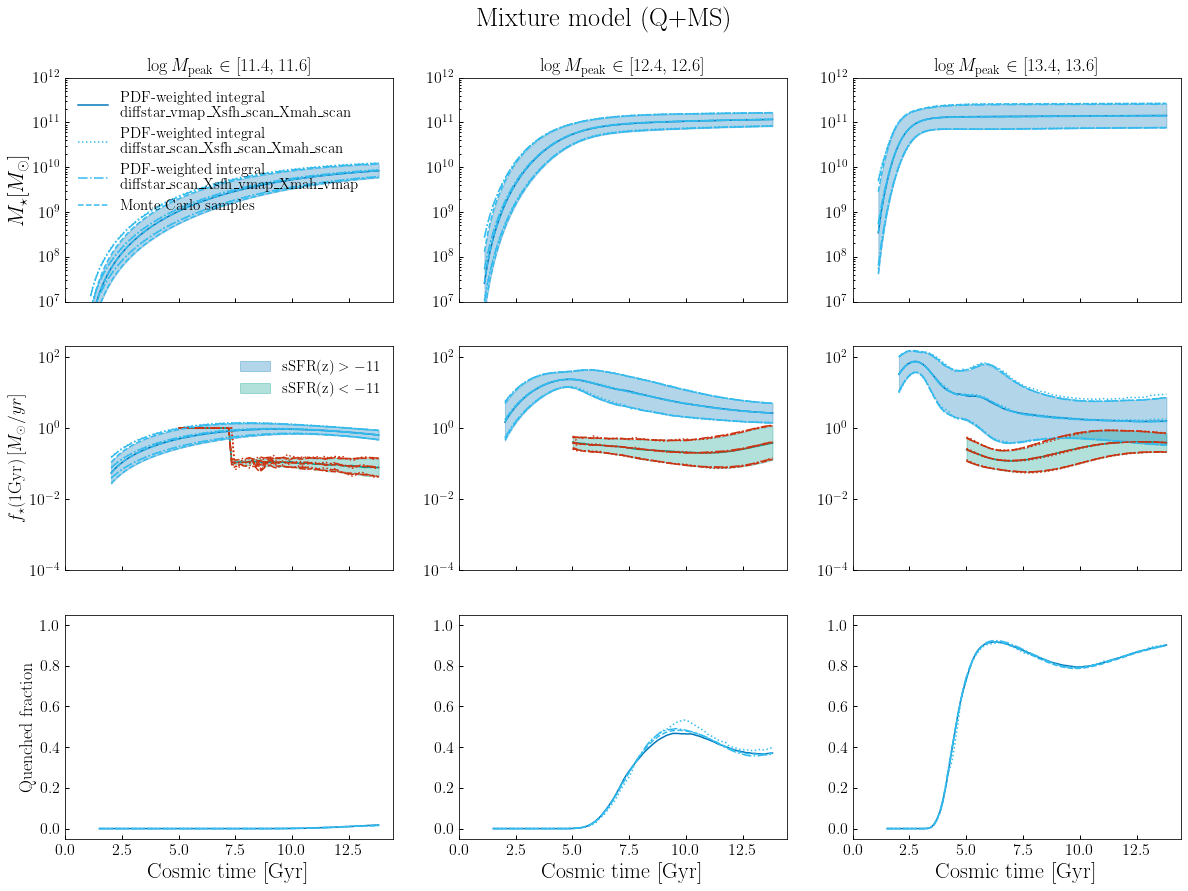

In [20]:
NM0 = len(logm0_binmids)


fontsize=22
fig, ax = plt.subplots(3,NM0, figsize=(20,14), sharex=True, sharey=False)

for i in range(NM0):
    #"""
    ax[0,i].plot(t_table[sm_loss_sel], 10**_target_res[0][i][sm_loss_sel], color=colors[0], label='PDF-weighted integral\n'+'diffstar\_vmap\_Xsfh\_scan\_Xmah\_scan')
    ax[0,i].fill_between(t_table[sm_loss_sel], 
                       10**(_target_res[0][i]-np.sqrt(_target_res[1][i]))[sm_loss_sel],
                       10**(_target_res[0][i]+np.sqrt(_target_res[1][i]))[sm_loss_sel],
                       color=colors[0],
                       alpha = 0.3         
                      )
    

    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**_target_res[2][i][fstar_loss_MS_sel], color=colors[0])
    ax[1,i].fill_between(t_table[index_select][fstar_loss_MS_sel], 
                       10**(_target_res[2][i]-np.sqrt(_target_res[4][i]))[fstar_loss_MS_sel],
                       10**(_target_res[2][i]+np.sqrt(_target_res[4][i]))[fstar_loss_MS_sel],
                       color=colors[0],
                       alpha = 0.3, label = r"$\rm{sSFR}(z) > -11$"         
                      )
    
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**_target_res[3][i][fstar_loss_Q_sel], color=colors[2])
    ax[1,i].fill_between(t_table[index_select][fstar_loss_Q_sel], 
                       10**(_target_res[3][i]-np.sqrt(_target_res[5][i]))[fstar_loss_Q_sel],
                       10**(_target_res[3][i]+np.sqrt(_target_res[5][i]))[fstar_loss_Q_sel],
                       color=colors[2],
                       alpha = 0.3, label = r"$\rm{sSFR}(z) < -11$"      
                      )
                      
    ax[2,i].plot(t_table[index_select], _target_res[6][i], color=colors[0])
    
    
    
    ax[0,i].plot(t_table[sm_loss_sel], 10**_target_res_scan[0][i][sm_loss_sel], ls=":", color=colors[1], label='PDF-weighted integral\n'+'diffstar\_scan\_Xsfh\_scan\_Xmah\_scan')
    ax[0,i].plot(t_table[sm_loss_sel], 10**(_target_res_scan[0][i]-np.sqrt(_target_res_scan[1][i]))[sm_loss_sel], ls=":", color=colors[1],)
    ax[0,i].plot(t_table[sm_loss_sel], 10**(_target_res_scan[0][i]+np.sqrt(_target_res_scan[1][i]))[sm_loss_sel], ls=":", color=colors[1],)

    

    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**_target_res_scan[2][i][fstar_loss_MS_sel], ls=":", color=colors[1])
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(_target_res_scan[2][i]-np.sqrt(_target_res_scan[4][i]))[fstar_loss_MS_sel], ls=":", color=colors[1],)
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(_target_res_scan[2][i]+np.sqrt(_target_res_scan[4][i]))[fstar_loss_MS_sel], ls=":", color=colors[1],)

    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**_target_res_scan[3][i][fstar_loss_Q_sel], ls=":", color=colors[4])
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(_target_res_scan[3][i]-np.sqrt(_target_res_scan[5][i]))[fstar_loss_Q_sel], ls=":", color=colors[4],)
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(_target_res_scan[3][i]+np.sqrt(_target_res_scan[5][i]))[fstar_loss_Q_sel], ls=":", color=colors[4],)

    ax[2,i].plot(t_table[index_select], _target_res_scan[6][i], ls=":", color=colors[1])
    
    ax[0,i].plot(t_table[sm_loss_sel], 10**_target_res_scan_vmap[0][i][sm_loss_sel], ls="-.", color=colors[1], label='PDF-weighted integral\n'+'diffstar\_scan\_Xsfh\_vmap\_Xmah\_vmap')
    ax[0,i].plot(t_table[sm_loss_sel], 10**(_target_res_scan_vmap[0][i]-np.sqrt(_target_res_scan_vmap[1][i]))[sm_loss_sel], ls="-.", color=colors[1],)
    ax[0,i].plot(t_table[sm_loss_sel], 10**(_target_res_scan_vmap[0][i]+np.sqrt(_target_res_scan_vmap[1][i]))[sm_loss_sel], ls="-.", color=colors[1],)

    

    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**_target_res_scan_vmap[2][i][fstar_loss_MS_sel], ls="-.", color=colors[1])
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(_target_res_scan_vmap[2][i]-np.sqrt(_target_res_scan_vmap[4][i]))[fstar_loss_MS_sel], ls="-.", color=colors[1],)
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(_target_res_scan_vmap[2][i]+np.sqrt(_target_res_scan_vmap[4][i]))[fstar_loss_MS_sel], ls="-.", color=colors[1],)

    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**_target_res_scan_vmap[3][i][fstar_loss_Q_sel], ls="-.", color=colors[4])
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(_target_res_scan_vmap[3][i]-np.sqrt(_target_res_scan_vmap[5][i]))[fstar_loss_Q_sel], ls="-.", color=colors[4],)
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(_target_res_scan_vmap[3][i]+np.sqrt(_target_res_scan_vmap[5][i]))[fstar_loss_Q_sel], ls="-.", color=colors[4],)

    ax[2,i].plot(t_table[index_select], _target_res_scan_vmap[6][i], ls="-.", color=colors[1])

    #"""
    ax[0,i].plot(t_table[sm_loss_sel], 10**_MC_res[0][i][sm_loss_sel], ls="--", color=colors[1], label='Monte Carlo samples')
    ax[0,i].plot(t_table[sm_loss_sel], 10**(_MC_res[0][i]-np.sqrt(_MC_res[1][i]))[sm_loss_sel], ls="--", color=colors[1],)
    ax[0,i].plot(t_table[sm_loss_sel], 10**(_MC_res[0][i]+np.sqrt(_MC_res[1][i]))[sm_loss_sel], ls="--", color=colors[1],)

    

    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**_MC_res[2][i][fstar_loss_MS_sel], ls="--", color=colors[1])
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(_MC_res[2][i]-np.sqrt(_MC_res[4][i]))[fstar_loss_MS_sel], ls="--", color=colors[1],)
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(_MC_res[2][i]+np.sqrt(_MC_res[4][i]))[fstar_loss_MS_sel], ls="--", color=colors[1],)

    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**_MC_res[3][i][fstar_loss_Q_sel], ls="--", color=colors[4])
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(_MC_res[3][i]-np.sqrt(_MC_res[5][i]))[fstar_loss_Q_sel], ls="--", color=colors[4],)
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(_MC_res[3][i]+np.sqrt(_MC_res[5][i]))[fstar_loss_Q_sel], ls="--", color=colors[4],)

    ax[2,i].plot(t_table[index_select], _MC_res[6][i], ls="--", color=colors[1])
        

    
    ax[0,i].set_yscale('log')
    ax[1,i].set_yscale('log')
    ax[0,i].set_ylim(1e7, 1e12)
    ax[1,i].set_ylim(1e-4, 2e2)
    ax[2,i].set_ylim(-0.05,1.05)
    ax[2,i].set_xlabel('Cosmic time [Gyr]', fontsize=fontsize)
    ax[0,i].set_title(r'$\log M_{\rm peak}\in[%.1f, %.1f]$'%(logm0_binmids[i]-logm0_bin_widths[i], logm0_binmids[i]+logm0_bin_widths[i]))

ax[0,0].legend()
ax[1,0].legend()
ax[0,0].set_xticks(np.arange(0,13,2.5))
ax[0,0].set_ylabel('$M_\star [M_{\odot}]$', fontsize=fontsize)
ax[1,0].set_ylabel('$f_\star(1\mathrm{Gyr}) \,[M_{\odot}/yr]$')
ax[2,0].set_ylabel('Quenched fraction')
fig.suptitle("Mixture model (Q+MS)", y=0.95)
#fig.savefig('mc_vs_pdfweight_sumstats_MIX.png', bbox_inches='tight', dpi=300)


In [22]:
_MC_res[6][0].shape, _MC_res[2][0].shape

((96,), (96,))

In [1]:
for i in range(3):
    plt.plot(_MC_res[6][i]-_target_res[6][i])


NameError: name '_MC_res' is not defined

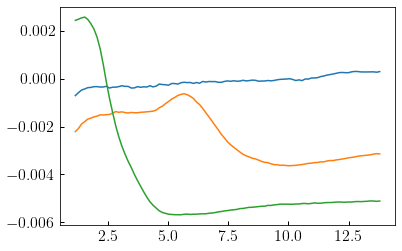

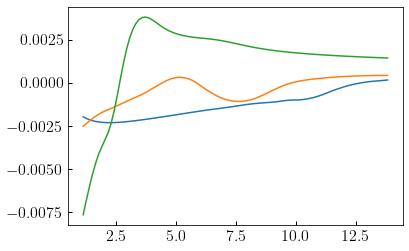

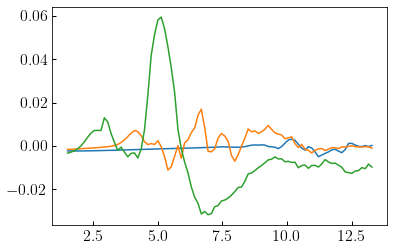

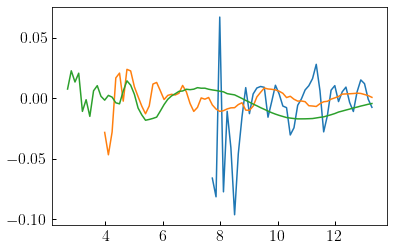

In [22]:
for i in range(3):
    plt.plot(t_table[sm_loss_sel], _MC_res[0][i][sm_loss_sel]-_target_res[0][i][sm_loss_sel])
plt.show()
for i in range(3):
    plt.plot(t_table[sm_loss_sel], np.sqrt(_MC_res[1][i])[sm_loss_sel]-np.sqrt(_target_res[1][i])[sm_loss_sel])
plt.show()
for i in range(3):
    plt.plot(t_table[fstar_loss_MS_sel], np.sqrt(_MC_res[4][i])[fstar_loss_MS_sel]-np.sqrt(_target_res[4][i])[fstar_loss_MS_sel])
plt.show()
for i in range(3):
    plt.plot(t_table[fstar_loss_MS_sel], np.sqrt(_MC_res[5][i])[fstar_loss_MS_sel]-np.sqrt(_target_res[5][i])[fstar_loss_MS_sel])
plt.show()

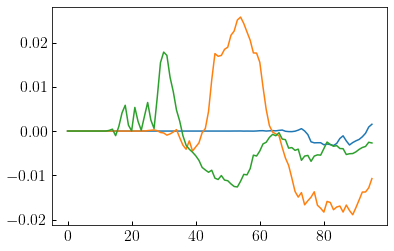

In [24]:
for i in range(3):
    plt.plot(_MC_res[6][i]-_target_res[6][i])


In [25]:
from diffstar.kernels

SyntaxError: invalid syntax (<ipython-input-25-1ff17dd608ad>, line 1)

Text(0, 0.5, 'Quenched fraction')

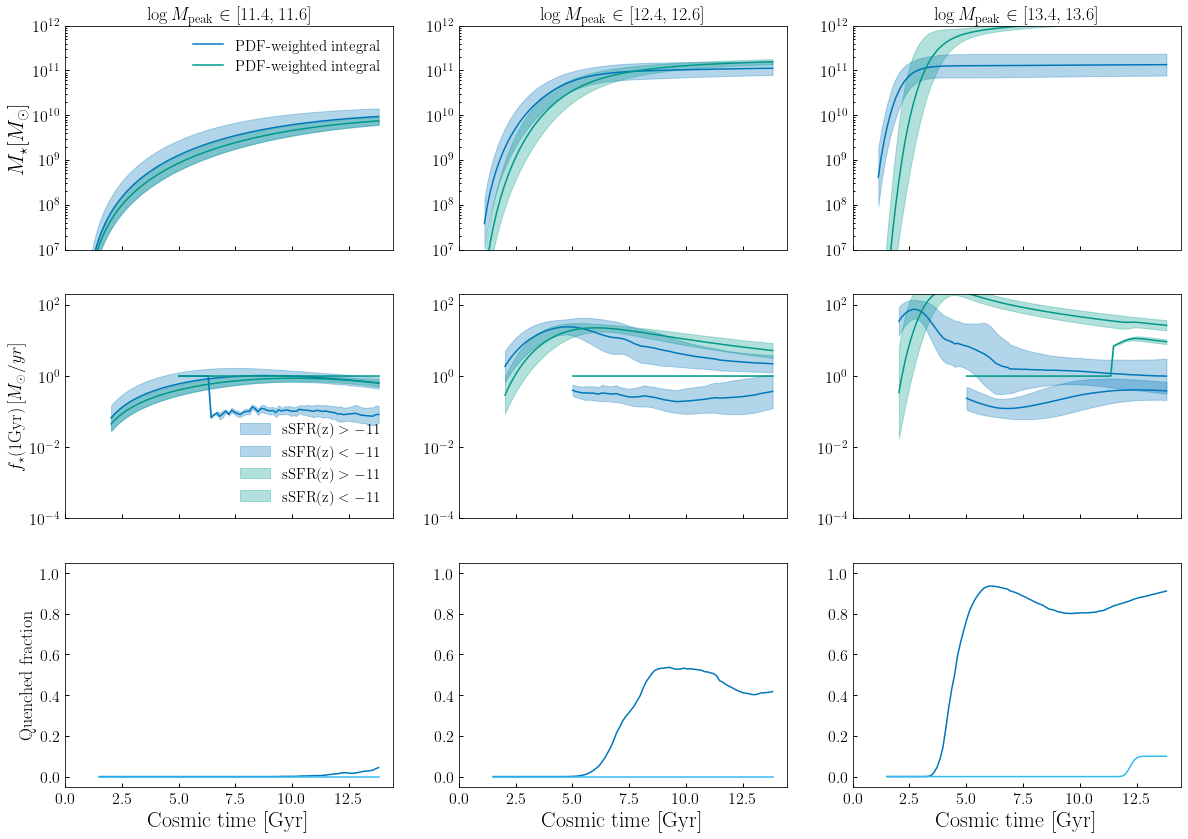

In [76]:
NM0 = len(logm0_binmids)


fontsize=22
fig, ax = plt.subplots(3,NM0, figsize=(20,14), sharex=True, sharey=False)

for i in range(NM0):
    #"""
    ax[0,i].plot(t_table[sm_loss_sel], 10**_target_res[0][i][sm_loss_sel], color=colors[0], label='PDF-weighted integral')
    ax[0,i].fill_between(t_table[sm_loss_sel], 
                       10**(_target_res[0][i]-np.sqrt(_target_res[1][i]))[sm_loss_sel],
                       10**(_target_res[0][i]+np.sqrt(_target_res[1][i]))[sm_loss_sel],
                       color=colors[0],
                       alpha = 0.3         
                      )
    

    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**_target_res[2][i][fstar_loss_MS_sel], color=colors[0])
    ax[1,i].fill_between(t_table[index_select][fstar_loss_MS_sel], 
                       10**(_target_res[2][i]-np.sqrt(_target_res[4][i]))[fstar_loss_MS_sel],
                       10**(_target_res[2][i]+np.sqrt(_target_res[4][i]))[fstar_loss_MS_sel],
                       color=colors[0],
                       alpha = 0.3, label = r"$\rm{sSFR}(z) > -11$"         
                      )
    
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**_target_res[3][i][fstar_loss_Q_sel], color=colors[0])
    ax[1,i].fill_between(t_table[index_select][fstar_loss_Q_sel], 
                       10**(_target_res[3][i]-np.sqrt(_target_res[5][i]))[fstar_loss_Q_sel],
                       10**(_target_res[3][i]+np.sqrt(_target_res[5][i]))[fstar_loss_Q_sel],
                       color=colors[0],
                       alpha = 0.3, label = r"$\rm{sSFR}(z) < -11$"      
                      )
                      
    ax[2,i].plot(t_table[index_select], _target_res[6][i], color=colors[0])

    ax[0,i].plot(t_table[sm_loss_sel], 10**_target_res_MS[0][i][sm_loss_sel], color=colors[2], label='PDF-weighted integral')
    ax[0,i].fill_between(t_table[sm_loss_sel], 
                       10**(_target_res_MS[0][i]-np.sqrt(_target_res_MS[1][i]))[sm_loss_sel],
                       10**(_target_res_MS[0][i]+np.sqrt(_target_res_MS[1][i]))[sm_loss_sel],
                       color=colors[2],
                       alpha = 0.3         
                      )
    

    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**_target_res_MS[2][i][fstar_loss_MS_sel], color=colors[2])
    ax[1,i].fill_between(t_table[index_select][fstar_loss_MS_sel], 
                       10**(_target_res_MS[2][i]-np.sqrt(_target_res_MS[4][i]))[fstar_loss_MS_sel],
                       10**(_target_res_MS[2][i]+np.sqrt(_target_res_MS[4][i]))[fstar_loss_MS_sel],
                       color=colors[2],
                       alpha = 0.3, label = r"$\rm{sSFR}(z) > -11$"         
                      )
    
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**_target_res_MS[3][i][fstar_loss_Q_sel], color=colors[2])
    ax[1,i].fill_between(t_table[index_select][fstar_loss_Q_sel], 
                       10**(_target_res_MS[3][i]-np.sqrt(_target_res_MS[5][i]))[fstar_loss_Q_sel],
                       10**(_target_res_MS[3][i]+np.sqrt(_target_res_MS[5][i]))[fstar_loss_Q_sel],
                       color=colors[2],
                       alpha = 0.3, label = r"$\rm{sSFR}(z) < -11$"      
                      )
                      
    ax[2,i].plot(t_table[index_select], _target_res_MS[6][i], color=colors[1])

    

    
    ax[0,i].set_yscale('log')
    ax[1,i].set_yscale('log')
    ax[0,i].set_ylim(1e7, 1e12)
    ax[1,i].set_ylim(1e-4, 2e2)
    ax[2,i].set_ylim(-0.05,1.05)
    ax[2,i].set_xlabel('Cosmic time [Gyr]', fontsize=fontsize)
    ax[0,i].set_title(r'$\log M_{\rm peak}\in[%.1f, %.1f]$'%(logm0_binmids[i]-logm0_bin_widths[i], logm0_binmids[i]+logm0_bin_widths[i]))

ax[0,0].legend()
ax[1,0].legend()
ax[0,0].set_xticks(np.arange(0,13,2.5))
ax[0,0].set_ylabel('$M_\star [M_{\odot}]$', fontsize=fontsize)
ax[1,0].set_ylabel('$f_\star(1\mathrm{Gyr}) \,[M_{\odot}/yr]$')
ax[2,0].set_ylabel('Quenched fraction')
#fig.savefig('test_mc_integration_target_from_model_fstar_validation_wrt_MonteCarlo.png', bbox_inches='tight', dpi=300)


In [ ]:
    ax[0,i].plot(t_table[sm_loss_sel], 10**_target_res_MS[0][i][sm_loss_sel], color=colors[0], label='PDF-weighted integral')
    ax[0,i].fill_between(t_table[sm_loss_sel], 
                       10**(_target_res_MS[0][i]-np.sqrt(_target_res_MS[1][i]))[sm_loss_sel],
                       10**(_target_res_MS[0][i]+np.sqrt(_target_res_MS[1][i]))[sm_loss_sel],
                       color=colors[0],
                       alpha = 0.3         
                      )
    

    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**_target_res_MS[2][i][fstar_loss_MS_sel], color=colors[0])
    ax[1,i].fill_between(t_table[index_select][fstar_loss_MS_sel], 
                       10**(_target_res_MS[2][i]-np.sqrt(_target_res_MS[4][i]))[fstar_loss_MS_sel],
                       10**(_target_res_MS[2][i]+np.sqrt(_target_res_MS[4][i]))[fstar_loss_MS_sel],
                       color=colors[0],
                       alpha = 0.3, label = r"$\rm{sSFR}(z) > -11$"         
                      )
    
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**_target_res_MS[3][i][fstar_loss_Q_sel], color=colors[2])
    ax[1,i].fill_between(t_table[index_select][fstar_loss_Q_sel], 
                       10**(_target_res_MS[3][i]-np.sqrt(_target_res_MS[5][i]))[fstar_loss_Q_sel],
                       10**(_target_res_MS[3][i]+np.sqrt(_target_res_MS[5][i]))[fstar_loss_Q_sel],
                       color=colors[2],
                       alpha = 0.3, label = r"$\rm{sSFR}(z) < -11$"      
                      )
                      
    ax[2,i].plot(t_table[index_select], _target_res_MS[6][i], color=colors[0])

    

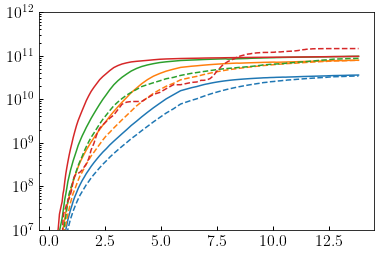

In [65]:
for i in range(4):
    line = plt.plot(SMDPL_t, 10**mstar_data_Q[i])[0]
    plt.plot(SMDPL_t, 10**mstar_data_MS[i], '--', color=line.get_color())
    
plt.ylim(1e7,1e12)
plt.yscale('log')

In [39]:
from diffstarpop.pdfmodel import UH
@jjit
def _sm_func_UH(
    lgt,
    dt,
    dmhdt,
    log_mah,
    sfr_ms_params,
    q_params,
    index_select,
    index_high,
    fstar_tdelay,
):
    sfr_params = [*sfr_ms_params[0:3], UH, sfr_ms_params[3]]
    return calculate_sm_sfr_fstar_history_from_mah(
        lgt,
        dt,
        dmhdt,
        log_mah,
        sfr_params,
        q_params,
        index_select,
        index_high,
        fstar_tdelay,
    )


_A = (None, None, 0, 0, None, None, None, None, None)
_B = (None, None, None, None, 0, 0, None, None, None)
sm_sfr_history_vmap_halos = jjit(vmap(_sm_func_UH, in_axes=_A))
sm_sfr_history_vmap = jjit(vmap(vmap(_sm_func_UH, in_axes=_A), _B))

In [40]:
from jax import lax
@jjit
def sm_sfr_history_scan(
    lgt,
    dt,
    dmhdt,
    log_mah,
    sfr_ms_params_arr,
    q_params_arr,
    index_select,
    index_high,
    fstar_tdelay,
):
    nmah = len(dmhdt)
    nsfh = len(sfr_ms_params_arr)
    nfstar = len(index_high)
    nt = len(lgt)
    
    init = (
        jnp.zeros((nmah, nt)),
        jnp.zeros((nmah, nt)),
        jnp.zeros((nmah, nfstar)),
    )
    @jjit
    def _testfun_scan(carry, data):
        sfr_ms_params, q_params = data
        _res = sm_sfr_history_vmap_halos(
            lgt,
            dt,
            dmhdt,
            log_mah,
            sfr_ms_params,
            q_params,
            index_select,
            index_high,
            fstar_tdelay,
        )
        return _res, _res
    
    data = (sfr_ms_params_arr, q_params_arr)
    result = lax.scan(_testfun_scan, init, data)
    
    return result[1] 

In [49]:
@jjit
def sm_sfr_history_scan_full(
    lgt,
    dt,
    dmhdt_arr,
    log_mah_arr,
    sfr_ms_params_arr,
    q_params_arr,
    index_select,
    index_high,
    fstar_tdelay,
):
    nmah = len(dmhdt_arr)
    nsfh = len(sfr_ms_params_arr)
    nfstar = len(index_high)
    nt = len(lgt)
    
    init1 = (
        jnp.zeros((nmah, nt)),
        jnp.zeros((nmah, nt)),
        jnp.zeros((nmah, nfstar)),
    )
    

    def _testfun_scan1(carry, data):
        sfr_ms_params, q_params = data
        
        
        def _testfun_scan2(carry2, data2):
            dmhdt, log_mah = data2
            
            _res = _sm_func_UH(
                lgt,
                dt,
                dmhdt,
                log_mah,
                sfr_ms_params,
                q_params,
                index_select,
                index_high,
                fstar_tdelay,
            )
            return _res, _res
        
        init2 = (
            jnp.zeros(nt),
            jnp.zeros(nt),
            jnp.zeros(nfstar)
        )
        
        data2 = (dmhdt_arr, log_mah_arr)
        result2 = lax.scan(_testfun_scan2, init2, data2)[1]
        
        return result2, result2
    
    data1 = (sfr_ms_params_arr, q_params_arr)
    result = lax.scan(_testfun_scan1, init1, data1)
    
    return result[1] 

In [42]:
_res_vmap = sm_sfr_history_vmap(
    jnp.log10(SMDPL_t),
    _get_dt_array(SMDPL_t),
    res_SMDPL[0][3][:10],
    res_SMDPL[0][4][:10],
    res_SMDPL[2][:5,[0,1,2,4]],
    res_SMDPL[2][:5,5:9],
    index_select_SMDPL,
    fstar_indx_high_SMDPL,
    fstar_tdelay,
)


In [53]:
_res_scan = sm_sfr_history_scan(
    jnp.log10(SMDPL_t),
    _get_dt_array(SMDPL_t),
    res_SMDPL[0][3][:10],
    res_SMDPL[0][4][:10],
    res_SMDPL[2][:5,[0,1,2,4]],
    res_SMDPL[2][:5,5:9],
    index_select_SMDPL,
    fstar_indx_high_SMDPL,
    fstar_tdelay,
)

In [54]:
_res_scan_full = sm_sfr_history_scan_full(
    jnp.log10(SMDPL_t),
    _get_dt_array(SMDPL_t),
    res_SMDPL[0][3][:10],
    res_SMDPL[0][4][:10],
    res_SMDPL[2][:5,[0,1,2,4]],
    res_SMDPL[2][:5,5:9],
    index_select_SMDPL,
    fstar_indx_high_SMDPL,
    fstar_tdelay,
)

In [55]:
_res_vmap[0].shape, _res_scan[0].shape, _res_scan_full[0].shape

((5, 10, 117), (5, 10, 117), (5, 10, 117))

In [56]:
for x,y in zip(_res_vmap, _res_scan):
    print(np.allclose(x,y, rtol=1e-3))
for x,y in zip(_res_vmap, _res_scan_full):
    print(np.allclose(x,y, rtol=1e-3))

True
True
True
True
True
True


In [112]:
_res_vmap[2][0,1] - _res_scan[2][0,1]



DeviceArray([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
              0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
              0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
              0.0000000e+00, -2.9802322e-08, -2.9802322e-08,
             -2.9802322e-08, -4.4703484e-08, -2.9802322e-08,
             -1.4901161e-08,  0.0000000e+00, -2.7939677e-08,
             -2.7474016e-08, -2.7706847e-08,  4.4237822e-09,
              6.3970219e-08,  3.2014214e-08,  3.1985110e-08,
              0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
              0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
              0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
              0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
              0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
              0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
              0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
              0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
              0.0000000e

In [ ]:
    sfh_lh_sig,
    t_table,
    n_sfh_param_grid,
    logm0_binmids,
    logm0_bin_widths,
    n_halos_per_bin,
    halo_data_validation,
    fstar_tdelay,
    init_params

In [65]:
        sfr_params_quench[:, :3] = sfh_params_quench[:, :3]
        sfr_params_quench[:, 3] = UH
        sfr_params_quench[:, 4] = sfh_params_quench[:, 3]
        q_params_quench = sfh_params_quench[:, 4:8]

    if n_haloes_MS > 1:
        _res = get_smah_means_and_covs_mainseq(logmh, **pdf_parameters)
        means_mainseq, covs_mainseq = _res
        means_mainseq = means_mainseq[0]
        covs_mainseq = covs_mainseq[0]

        sfh_params_mainseq = RandomState(seed + 1).multivariate_normal(
            means_mainseq, covs_mainseq, size=n_haloes_MS
        )
        sfr_params_mainseq[:, :3] = sfh_params_mainseq[:, :3]
        sfr_params_mainseq[:, 3] = UH
        sfr_params_mainseq[:, 4] = sfh_params_mainseq[:, 3]
        q_params_mainseq = np.zeros((n_haloes_MS, 4))
        q_params_mainseq[:, np.arange(4)] = DEFAULT_UNBOUND_Q_PARAMS_MAIN_SEQ

    sfr_params = np.concatenate((sfr_params_mainseq, sfr_params_quench))
    q_params = np.concatenate((q_params_mainseq, q_params_quench))

array([12.3787  ,  2.78867 ,  0.874736,  0.973339])

In [29]:
n_haloes = 1000
frac_quench = 1.0
n_haloes_Q = int(n_haloes * frac_quench)
n_haloes_MS = n_haloes - n_haloes_Q
sfr_params_quench = np.zeros((n_haloes_Q, 5))
sfr_params_mainseq = np.zeros((n_haloes_MS, 5))
sfr_params = np.concatenate((sfr_params_mainseq, sfr_params_quench))

sfr_params_quench.shape, sfr_params_mainseq.shape, sfr_params.shape

((1000, 5), (0, 5), (1000, 5))

In [65]:
from scipy import stats

@jjit
def _dumb(x, a, b):
    return a*x + b
_dumb = jjit(vmap(vmap(_dumb, in_axes=(0, None, None)), in_axes=(None, 0, 0)))
_t = np.linspace(-3,3,50)

data_a = ([0.0, 0.0], np.identity(2))
data_b = ([1.0, 2.0], np.identity(2))



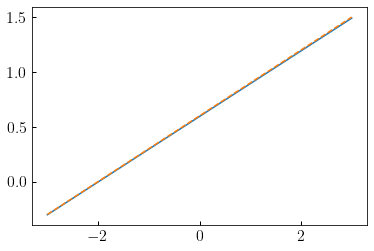

In [103]:
N = 100000
frac = 0.7

Na = int(N*frac)
Nb = N - Na

points_a = np.random.multivariate_normal(data_a[0], data_a[1], (Na))
points_b = np.random.multivariate_normal(data_b[0], data_b[1], (Nb))

histories_a = _dumb(_t, *points_a.T)
histories_b = _dumb(_t, *points_b.T)
histories_MC = np.concatenate((histories_a, histories_b), axis=0)


points_grid_a = np.array([np.random.uniform(-3,3, N), np.random.uniform(-3,3, N)]).T
points_grid_b = np.array([np.random.uniform(-2,4, N), np.random.uniform(-1,5, N)]).T

histories_pdf_a = _dumb(_t, *points_grid_a.T)
histories_pdf_b = _dumb(_t, *points_grid_b.T)

weights_a = frac * stats.multivariate_normal(mean=data_a[0], cov=data_a[1]).pdf(points_grid_a)
weights_b = (1 - frac) * stats.multivariate_normal(mean=data_b[0], cov=data_b[1]).pdf(points_grid_b)

histories_pdf = np.concatenate((histories_pdf_a, histories_pdf_b), axis=0)
weights = np.concatenate((weights_a, weights_b), axis=0)


plt.plot(_t, np.mean(histories_MC, axis=0))
plt.plot(_t, np.average(histories_pdf, weights=weights, axis=0), ls='--')


In [29]:
! ~/

zsh:1: permission denied: /Users/alarcon/


In [11]:
import pandas as pd

df = pd.read_parquet("~/Downloads/12309.parquet")

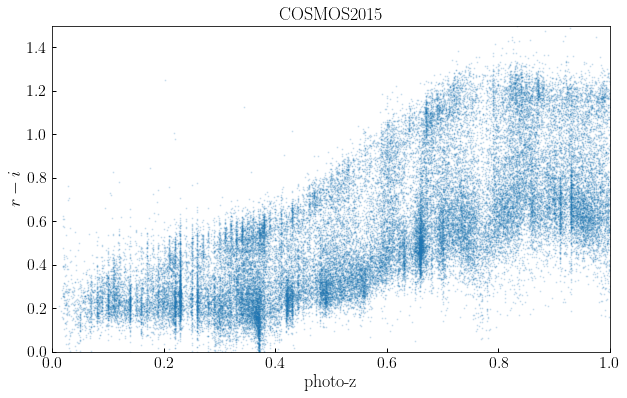

In [30]:
plt.figure(figsize=(10,6))
plt.scatter(df.photoz.values, df.r_i.values, s=1, alpha=0.15)
plt.ylim(0.0, 1.5)
plt.xlim(0.0, 1.0)
plt.title('COSMOS2015')
plt.xlabel("photo-z")
plt.ylabel(r"$r-i$")
plt.savefig("/Users/alarcon/Downloads/test.png", bbox_inches='tight', dpi=300)